In [32]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import seaborn as sns
import importlib
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing as mp
import importlib

path_figs = "./Figs/"

# path = "./SL3/SL3"
path = "./sh4/"

path_misc = "./sh4_miscs/"

fingers = [0, 1, 2, 3, 4]

iti = 500

total_sub_num = 40

subjs_ids = {
    'BH', 'BI2', 'CBC', 'CD', 'CES', 'CLD', 'CM', 'CMM', 'CNB', 'CNN', 'CS', 'CWT', 'CZE', 'DH',
    'IL', 'KA', 'KF', 'KQ', 'MAK', 'MDT', 'MDX', 'MEW', 'MGC', 'MHK', 'MIB', 'MIE', 'MIL', 'MNI',
    'MOH', 'MOT', 'MTS', 'MTS2', 'MUU', 'MZT', 'QQ', 'TE', 'TI', 'UC', 'UO', 'ZQ', 'LI'
}

seq_dict = {
    'G1': {
        'aligned': [1, 2, 4], 
        'unaligned': [3, 6, 7],
        'control': [5]
    } ,
    'G2': {
        'aligned': [3, 6, 7],
        'unaligned': [1, 2, 4],
        'control': [5]
    }

}

# subjs_ids = {
#     'BH', 'BI2', 'CBC', 'CD', 'CES', 'CLD', 'CM', 'CMM', 'CNB', 'CNN', 'CS', 'CWT', 'CZE', 'DH',
#     'IL', 'KA', 'KF', 'KQ', 'MAK', 'MDT', 'MDX', 'MEW', 'MGC', 'MHK', 'MIB', 'MIE', 'MIL', 'MNI',
#     'MOH', 'MOT', 'MTS', 'MTS2', 'MUU', 'MZT', 'QQ', 'TE', 'TI', 'UC', 'UO', 'ZQ'
# }


In [33]:
importlib.reload(utils)

<module 'utils' from '/Users/amin/projects/SequenceHierarchical/utils.py'>

In [34]:
subjs = pd.concat(utils.read_dat_files_subjs_list())
utils.add_IPI(subjs)
subjs.sort_values(by = ['SubNum', 'BN', 'TN'], inplace=True)
subjs = subjs.reset_index(drop=True)

Preferred file for subject MIB: ./sh4/data/sh3_MIB.dat
Preferred file for subject MEW: ./sh4/data/sh3_MEW.dat
Preferred file for subject MDT: ./sh4/data/sh3_MDT.dat
Preferred file for subject MIE: ./sh4/data/sh3_MIE.dat
Preferred file for subject MAK: ./sh4/data/sh3_MAK.dat
Preferred file for subject MZT: ./sh4/data/sh3_MZT.dat
Preferred file for subject MOT: ./sh4/data/sh3_MOT.dat
Preferred file for subject CLD: ./sh4/data/sh3_CLD.dat
Preferred file for subject CNN: ./sh4/data/sh3_CNN.dat
Preferred file for subject MOH: ./sh4/data/sh3_MOH.dat
Preferred file for subject CNB: ./sh4/data/sh3_CNB.dat
Preferred file for subject CZE: ./sh4/data/sh3_CZE.dat
Preferred file for subject CBC: ./sh4/data/sh3_CBC.dat
Preferred file for subject CMM: ./sh4/data/sh3_CMM.dat
Preferred file for subject CWT: ./sh4/data/sh3_CWT.dat
Preferred file for subject MTS: ./sh4/data/sh3_MTS.dat
Preferred file for subject MNI: ./sh4/data/sh3_MNI.dat
Preferred file for subject MUU: ./sh4/data/sh3_MUU.dat
Preferred 

In [35]:
#removing duplicates from subjs
subjs = subjs.drop_duplicates(subset=['SubNum', 'BN', 'TN'], keep='last').reset_index(drop=True)

In [39]:
unique_blocks_per_subject = subjs.groupby('SubNum')['BN'].nunique()
unique_blocks_per_subject
# flag subjects with 200 BN as control subjects in subjs
control_subjs = unique_blocks_per_subject[unique_blocks_per_subject == 200].index
control_subjs
subjs['control'] = subjs['SubNum'].apply(lambda x: x in control_subjs)

# discard subjects with 207 unique blocks
discard_subjs = unique_blocks_per_subject[unique_blocks_per_subject == 207].index
discard_subjs
subjs = subjs[~ subjs['SubNum'].isin(discard_subjs)].reset_index(drop = True)


In [40]:
control_subjs

Index(['CBC', 'CES', 'CLD', 'CMM', 'CNB', 'CNN', 'CWT', 'CZE'], dtype='object', name='SubNum')

In [41]:
discard_subjs

Index([], dtype='object', name='SubNum')

In [42]:
chunk_dict = {
    "G1": {
        "A": "32",
        "B": "34",
        "C": "113",
        "D": "123",
        "E": "321",
        "F": "343",
        "G": "353",
        "H": "435",
        "I": "443",
        "J": "512",
        "K": "513",
    },
    "G2": {
        "A": "12",
        "B": "43",
        "C": "123",
        "D": "134",
        "E": "135",
        "F": "235",
        "G": "321",
        "H": "332",
        "I": "341",
        "J": "351",
        "K": "551",
    }
}


sub_group = {}
for subnum, subjs_data in subjs.groupby('SubNum'):
    if subjs_data['control'].iloc[0]:
        continue
    # print(subnum)
    # print(subjs_data[['cueC', 'cueP']].iloc[126])
    # print(subjs_data['cueC'].iloc[126])
    # print(subjs_data['cueP'].iloc[126])
    #based on the cueC and cueP values, we can determine the group based on the chunk_dict
    for group, chunks in chunk_dict.items():
        if chunks[subjs_data['cueC'].iloc[126]] == subjs_data['cueP'].iloc[126]:
            # print(group)
            sub_group[subnum] = group
    

In [43]:
sub_group

{'BH': 'G1',
 'BI2': 'G2',
 'CD': 'G1',
 'CM': 'G1',
 'CS': 'G1',
 'DH': 'G2',
 'IL': 'G1',
 'KA': 'G1',
 'KQ': 'G2',
 'MAK': 'G1',
 'MDT': 'G1',
 'MDX': 'G2',
 'MEW': 'G2',
 'MGC': 'G2',
 'MHK': 'G1',
 'MIB': 'G1',
 'MIE': 'G2',
 'MIL': 'G1',
 'MNI': 'G1',
 'MOH': 'G2',
 'MOT': 'G2',
 'MTS': 'G1',
 'MTS2': 'G2',
 'MUU': 'G1',
 'MZT': 'G2',
 'QQ': 'G2',
 'TI': 'G2',
 'UC': 'G1',
 'UO': 'G2',
 'ZQ': 'G2'}

In [16]:
specific_sequences = np.arange(1,8)
induction_blocks_treatment = np.arange(1, 62)
optimization_blocks_treatment = np.arange(62, 188)
memory_optimization_blocks_treatment = np.arange(62, 138)

induction_blocks_control = np.arange(1, 52)
optimization_blocks_control = np.arange(52, 178)
memory_topimization_blocks_control = np.arange(52, 128)
subjs_seq = subjs[subjs['seqNumb'].isin(specific_sequences)].reset_index(drop = True)

# for control subjects, select induction and optimization blocks
subjs_seq_control = subjs_seq[subjs_seq['control']].reset_index(drop=True)
subjs_seq_control_induction = subjs_seq_control[subjs_seq_control['BN'].isin(induction_blocks_control)].reset_index(drop=True)
subjs_seq_control_optimization = subjs_seq_control[subjs_seq_control['BN'].isin(optimization_blocks_control)].reset_index(drop=True)

# for treatment subjects, select induction and optimization blocks
subjs_seq_treatment = subjs_seq[~subjs_seq['control']]
# add group column to subjs_seq_treatment based on sub_group
subjs_seq_treatment['group'] = subjs_seq_treatment['SubNum'].map(sub_group)
# based on group column and seq_dict, add a column to subjs_seq_treatment to indicate the type of sequence
subjs_seq_treatment['seq_type'] = subjs_seq_treatment.apply(utils.seq_type_mapping, axis=1)
subjs_seq_treatment = subjs_seq_treatment.reset_index(drop=True)

subjs_seq_treatment_induction = subjs_seq_treatment[subjs_seq_treatment['BN'].isin(induction_blocks_treatment)].reset_index(drop=True)
subjs_seq_treatment_optimization = subjs_seq_treatment[subjs_seq_treatment['BN'].isin(optimization_blocks_treatment)].reset_index(drop=True)

subjs_seq_control_optimization['rep'] = subjs_seq_control_optimization.groupby(['SubNum', 'BN'])['seqNumb'].shift(1) == subjs_seq_control_optimization['seqNumb']
subjs_seq_control_optimization['rep'] = subjs_seq_control_optimization['rep'].fillna(False)
subjs_seq_treatment_optimization['rep'] = subjs_seq_treatment_optimization.groupby(['SubNum', 'BN'])['seqNumb'].shift(1) == subjs_seq_treatment_optimization['seqNumb']
subjs_seq_treatment_optimization['rep'] = subjs_seq_treatment_optimization['rep'].fillna(False)


/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_63037/382901573.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjs_seq_treatment['group'] = subjs_seq_treatment['SubNum'].map(sub_group)
/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_63037/382901573.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjs_seq_treatment['seq_type'] = subjs_seq_treatment.apply(utils.seq_type_mapping, axis=1)


In [17]:
print(subjs['SubNum'].nunique())
print(subjs_seq_control['SubNum'].nunique())
print(subjs_seq_treatment[subjs_seq_treatment['group'] == 'G1']['SubNum'].nunique())
print(subjs_seq_treatment[subjs_seq_treatment['group'] == 'G2']['SubNum'].nunique())


38
8
15
15


In [18]:
for subj_id in subjs_ids:
    print(len(subjs_seq_treatment_optimization[subjs_seq_treatment_optimization['SubNum'] == subj_id]))
for subj_id in subjs_ids:
    print(len(subjs_seq_control_optimization[subjs_seq_control_optimization['SubNum'] == subj_id]))

3276
3276
3276
3276
3276
0
0
0
3276
3276
0
3276
3276
3276
3276
3276
3276
3276
3276
3276
3276
3276
0
3276
0
3276
3276
3276
3276
3276
3276
0
0
3276
0
3276
0
3276
0
3276
3276
0
0
0
0
0
0
0
3276
0
0
3276
0
0
0
0
0
0
0
0
0
0
0
3276
0
3276
0
0
0
0
0
0
0
3276
0
3276
0
3276
0
3276
0
0


In [ ]:
importlib.reload(utils)

In [16]:
# subjs_presses = utils.finger_melt(subjs)
# subjs_presses_seq = utils.finger_melt(subjs_seq)
# subjs_presses_seq_treatment = utils.finger_melt_treatment(subjs_seq_treatment)
# subjs_presses_seq_control = utils.finger_melt(subjs_seq_control)

In [16]:
# subjs_presses.to_csv(path_misc + "subjs_presses.csv", index=False)
# subjs_presses_seq.to_csv(path_misc + "subjs_presses_seq.csv", index=False)
# subjs_presses_seq_treatment.to_csv(path_misc + "subjs_presses_seq_treatment.csv", index=False)
# subjs_presses_seq_control.to_csv(path_misc + "subjs_presses_seq_control.csv", index=False)

In [44]:
subjs_seq_treatment_induction

,BN,TN,seqNumb,FT,press0,press1,press2,press3,press4,press5,...,IPI5,IPI6,IPI7,IPI8,IPI9,IPI10,IPI0,control,group,seq_type
0,1,13,4,7,3,4,1,1,3,5,...,360.0,474.0,434.0,420.0,214.0,294.0,694.0,False,G1,aligned
1,1,14,4,7,3,4,1,1,3,5,...,406.0,316.0,346.0,342.0,310.0,450.0,1240.0,False,G1,aligned
2,1,19,3,7,4,3,5,5,1,2,...,286.0,324.0,382.0,400.0,282.0,268.0,1350.0,False,G1,unaligned
3,1,20,3,7,4,3,5,5,1,2,...,336.0,336.0,366.0,350.0,222.0,302.0,902.0,False,G1,unaligned
4,1,23,1,7,3,2,1,1,3,5,...,314.0,352.0,356.0,350.0,282.0,178.0,1254.0,False,G1,aligned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33147,61,24,6,9,1,2,3,5,1,3,...,90.0,190.0,168.0,150.0,98.0,124.0,2048.0,False,G2,aligned
33148,61,25,1,9,3,2,1,1,3,5,...,142.0,192.0,48.0,146.0,146.0,136.0,2930.0,False,G2,unaligned
33149,61,26,2,9,3,2,1,1,3,5,...,120.0,186.0,62.0,178.0,182.0,116.0,1122.0,False,G2,unaligned
33150,61,27,4,9,3,4,1,1,3,5,...,138.0,204.0,84.0,168.0,194.0,126.0,1534.0,False,G2,unaligned


In [23]:
subjs_presses = pd.read_csv(path_misc + "subjs_presses.csv")
subjs_presses_seq = pd.read_csv(path_misc + "subjs_presses_seq.csv")
subjs_presses_seq_treatment = pd.read_csv(path_misc + "subjs_presses_seq_treatment.csv")
subjs_presses_seq_control = pd.read_csv(path_misc + "subjs_presses_seq_control.csv")

In [15]:
%matplotlib inline

In [ ]:
subjs_seq['MT'].sort_values()[-10:-1]

In [ ]:
subjs.columns

In [ ]:
subjs['iti']

In [ ]:
sns.histplot(subjs_seq['MT'])
plt.axvline(subjs_seq['MT'].median(), 0, 1000, color='red')
plt.xlim(0, 10000)
print('MT median:', subjs_seq['MT'].median())

In [ ]:
sns.histplot(subjs_seq['IPI0'])
plt.axvline(subjs_seq['IPI0'].median(), 0, 1000, color='red')
plt.xlim(0, 10000)
print('RT median:', subjs_seq['IPI0'].median())

In [133]:
x = subjs_seq.sort_values(by = 'IPI0')

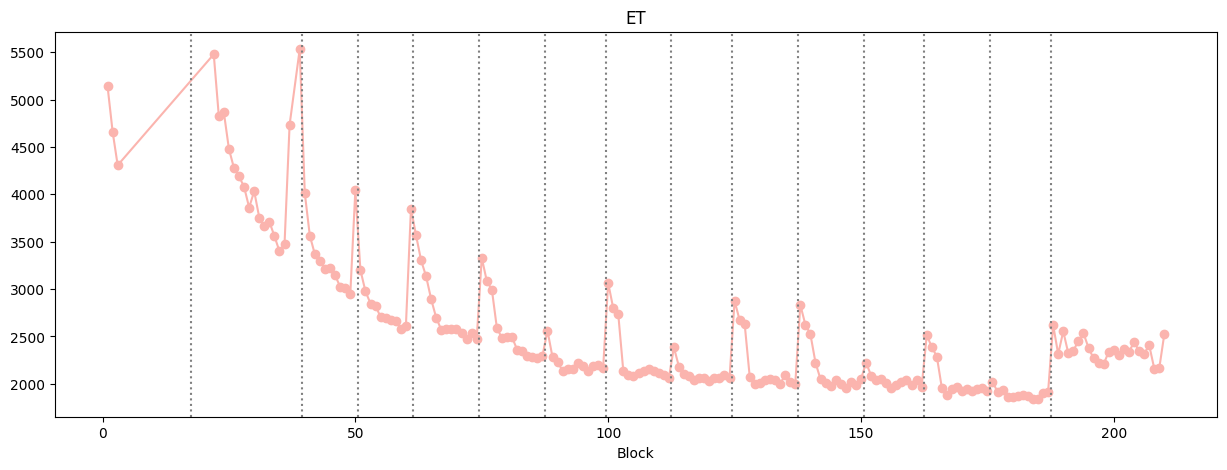

In [19]:
from matplotlib import cm
cmap = cm.Pastel1

plt.figure(figsize=(15, 5))


day_change_blocks = [17, 39, 50, 61, 74, 87, 99, 112, 124, 137, 150, 162, 175, 187]

subjs_seq_treatment_correct = utils.remove_error_trials(subjs_seq_treatment)

session_grouped = subjs_seq_treatment_correct.groupby(['BN', 'SubNum']).agg({
    'MT': 'median'
}).reset_index()
       

session_grouped = session_grouped.groupby(['BN']).agg({
    'MT': 'mean'
}).reset_index()

plt.plot(session_grouped['BN'], session_grouped['MT'], marker = 'o', color = cmap(0))


for day_change in day_change_blocks:
    plt.axvline(day_change + 0.5, linestyle = 'dotted', color = 'gray')

plt.title('ET')

plt.xlabel('Block')


plt.show()

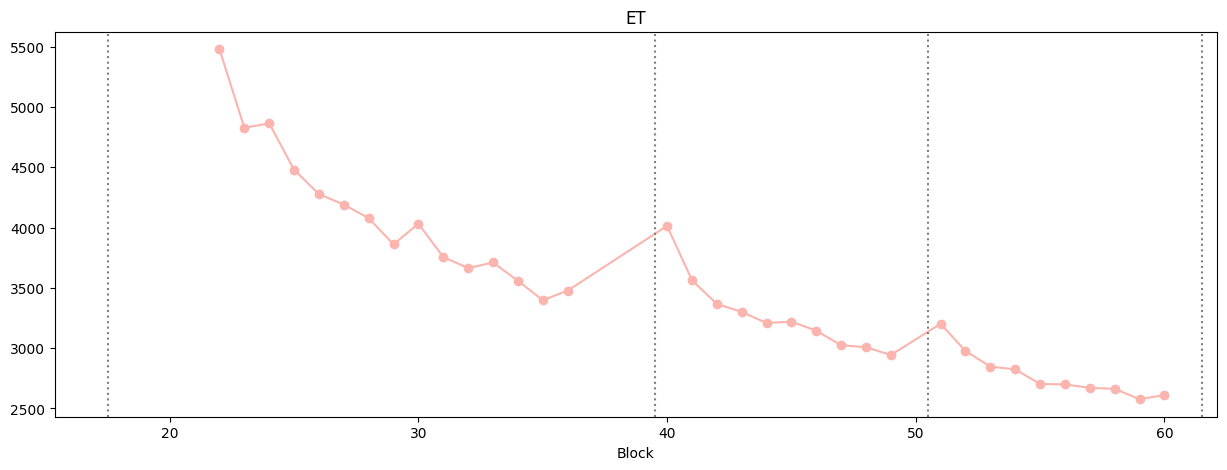

In [64]:
from matplotlib import cm
cmap = cm.Pastel1

plt.figure(figsize=(15, 5))


day_change_blocks = [17, 39, 50, 61]
recall_blocks = [39, 50, 37, 61]
day1_blocks = [1,2,3]

subjs_seq_treatment_correct = utils.remove_error_trials(subjs_seq_treatment_induction)

# remove recall blocks 
subjs_seq_treatment_correct = subjs_seq_treatment_correct[~subjs_seq_treatment_correct['BN'].isin(recall_blocks)]

#remove day 1 blocks
subjs_seq_treatment_correct = subjs_seq_treatment_correct[~subjs_seq_treatment_correct['BN'].isin(day1_blocks)]


# subjs_seq_treatment_correct = subjs_seq_treatment_correct[subjs_seq_treatment_correct['BN'] != 36]


session_grouped = subjs_seq_treatment_correct.groupby(['BN', 'SubNum']).agg({
    'MT': 'median'
}).reset_index()
       

session_grouped = session_grouped.groupby(['BN']).agg({
    'MT': 'mean'
}).reset_index()

plt.plot(session_grouped['BN'], session_grouped['MT'], marker = 'o', color = cmap(0))


for day_change in day_change_blocks:
    plt.axvline(day_change + 0.5, linestyle = 'dotted', color = 'gray')

plt.title('ET')

plt.xlabel('Block')


plt.show()

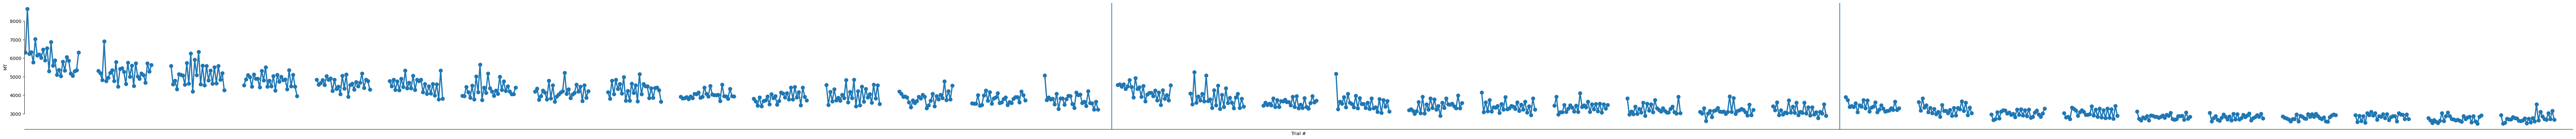

In [164]:
from matplotlib import cm
cmap = cm.Pastel1

plt.figure(figsize=(100, 5))


day_change_blocks = [17, 39, 50, 61]
recall_blocks = [39, 50, 37, 61]
day1_blocks = [1,2,3]

subjs_seq_treatment_correct = subjs_seq_treatment_induction.copy()

# remove recall blocks 
subjs_seq_treatment_correct = subjs_seq_treatment_correct[~subjs_seq_treatment_correct['BN'].isin(recall_blocks)]

#remove day 1 blocks
subjs_seq_treatment_correct = subjs_seq_treatment_correct[~subjs_seq_treatment_correct['BN'].isin(day1_blocks)].reset_index(drop=True)


rank_df = pd.DataFrame(index = subjs_seq_treatment_correct.index, dtype='int')
for subnum, data in subjs_seq_treatment_correct.groupby('SubNum'):
    data = data.sort_values(by = ['BN', 'TN'])
    data['Rank'] = data.groupby(['BN', 'TN']).ngroup() + 1
    rank_df.loc[data.index, 'Rank'] = data['Rank'].astype('int')
subjs_seq_treatment_correct['Rank'] = rank_df['Rank'].astype('int')

subjs_seq_treatment_correct = utils.remove_error_trials(subjs_seq_treatment_correct)

        

gap_x_values = []
gap_y_values = []
new_x_values = []
new_y_values = []
gap = 10
offset = gap
num_trials_per_block = 28

for idx , (bn, data) in enumerate(subjs_seq_treatment_correct.groupby('BN')):
    # if (bn == 60):
    #     print(data['Rank'].value_counts())
    data['Rank'] = data['Rank'] + idx * gap
    sns.pointplot(x = 'Rank', y = 'MT', data = data, color = sns.color_palette()[0], errorbar=None)
    # insert blank gap between blocks artificial
    gap_x_values = np.array(range(idx * num_trials_per_block, (idx + 1) * num_trials_per_block)) + offset
    gap_y_values = [np.nan] * len(np.array(range(idx * num_trials_per_block, (idx + 1) * num_trials_per_block)))
    # gap_x_values = (np.array(range(data['Rank'].min(), data['Rank'].max())) + offset)
    # gap_y_values = [np.nan] * len(np.array(range(data['Rank'].min(), data['Rank'].max())))
    

    sns.pointplot(x = gap_x_values, y = gap_y_values, color = 'black')

    if bn-1 in day_change_blocks:
        if idx == 15:
            plt.axvline((idx-1) * num_trials_per_block + idx * gap + gap)
        else:
            plt.axvline((idx-1) * num_trials_per_block + idx * gap)


    offset += gap


# plt.plot(session_grouped['BN'], session_grouped['MT'], marker = 'o', color = cmap(0))


# for day_change in day_change_blocks:
#     plt.axvline(day_change + 0.5, linestyle = 'dotted', color = 'gray')

# plt.title('ET')

plt.xlabel('Trial #')
plt.xticks([])
sns.despine(trim=True)

plt.savefig(path_figs + 'ET_all_trials.pdf', bbox_inches='tight')

# plt.show()

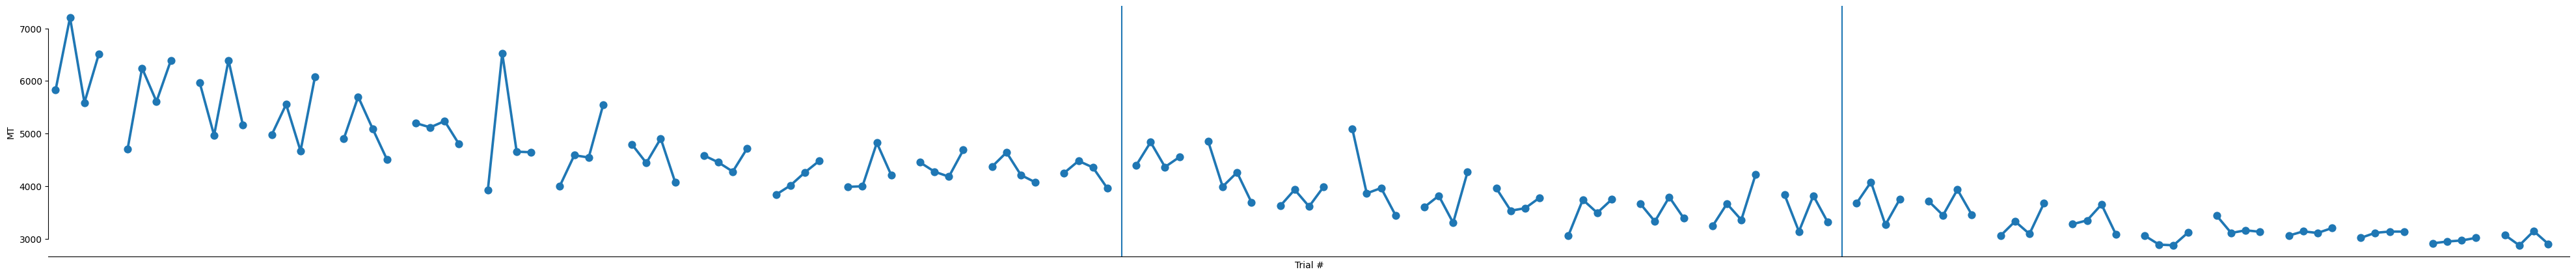

In [209]:
from matplotlib import cm
cmap = cm.Pastel1

plt.figure(figsize=(50, 5))


day_change_blocks = [17, 39, 50, 61]
recall_blocks = [39, 50, 37, 61]
day1_blocks = [1,2,3]

subjs_seq_treatment_correct = subjs_seq_treatment_induction.copy()

#select a specific seq
subjs_seq_treatment_correct = subjs_seq_treatment_correct[subjs_seq_treatment_correct['seqNumb'] == 3]

# remove recall blocks 
subjs_seq_treatment_correct = subjs_seq_treatment_correct[~subjs_seq_treatment_correct['BN'].isin(recall_blocks)]

#remove day 1 blocks
subjs_seq_treatment_correct = subjs_seq_treatment_correct[~subjs_seq_treatment_correct['BN'].isin(day1_blocks)].reset_index(drop=True)


rank_df = pd.DataFrame(index = subjs_seq_treatment_correct.index, dtype='int')
for subnum, data in subjs_seq_treatment_correct.groupby('SubNum'):
    data = data.sort_values(by = ['BN', 'TN'])
    data['Rank'] = data.groupby(['BN', 'TN']).ngroup() + 1
    rank_df.loc[data.index, 'Rank'] = data['Rank'].astype('int')
subjs_seq_treatment_correct['Rank'] = rank_df['Rank'].astype('int')

subjs_seq_treatment_correct = utils.remove_error_trials(subjs_seq_treatment_correct)

        

gap_x_values = []
gap_y_values = []
new_x_values = []
new_y_values = []
gap = 2
offset = gap
num_trials_per_block = 4

for idx , (bn, data) in enumerate(subjs_seq_treatment_correct.groupby('BN')):
    # if (bn == 60):
    #     print(data['Rank'].value_counts())
    data['Rank'] = data['Rank'] + offset
    sns.pointplot(x = 'Rank', y = 'MT', data = data, color = sns.color_palette()[0], errorbar=None)
    # insert blank gap between blocks artificial
    gap_x_values = np.array(range(idx * num_trials_per_block, (idx + 1) * num_trials_per_block)) + offset
    gap_y_values = [np.nan] * len(np.array(range(idx * num_trials_per_block, (idx + 1) * num_trials_per_block)))
    # gap_x_values = (np.array(range(data['Rank'].min(), data['Rank'].max())) + offset)
    # gap_y_values = [np.nan] * len(np.array(range(data['Rank'].min(), data['Rank'].max())))
    

    sns.pointplot(x = gap_x_values, y = gap_y_values, color = 'black')

    if bn-1 in day_change_blocks:
        if idx == 15:
            plt.axvline((idx-3) * num_trials_per_block + gap * (idx - 2))
        else:
            plt.axvline((idx-5) * num_trials_per_block + gap * (idx - 3))


    offset += gap


# plt.plot(session_grouped['BN'], session_grouped['MT'], marker = 'o', color = cmap(0))


# for day_change in day_change_blocks:
#     plt.axvline(day_change + 0.5, linestyle = 'dotted', color = 'gray')

# plt.title('ET')

plt.xlabel('Trial #')
plt.xticks([])
sns.despine(trim=True)

plt.savefig(path_figs + 'ET_all_trials.pdf', bbox_inches='tight')

# plt.show()

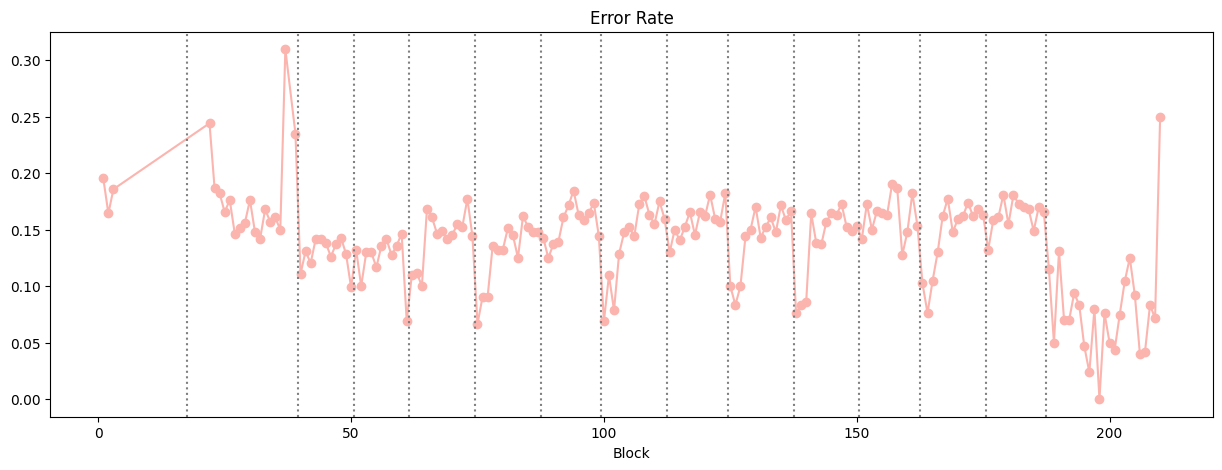

In [20]:
from matplotlib import cm
cmap = cm.Pastel1

plt.figure(figsize=(15, 5))


day_change_blocks = [17, 39, 50, 61, 74, 87, 99, 112, 124, 137, 150, 162, 175, 187]


session_grouped = subjs_seq_treatment.groupby(['BN', 'SubNum']).agg({
    'isError': 'sum', 
    'TN': 'count'
}).reset_index()
session_grouped['error_rate'] = session_grouped['isError'] / session_grouped['TN']
       

session_grouped = session_grouped.groupby(['BN']).agg({
    'error_rate': 'mean'
}).reset_index()

plt.plot(session_grouped['BN'], session_grouped['error_rate'], marker = 'o', color = cmap(0))


for day_change in day_change_blocks:
    plt.axvline(day_change + 0.5, linestyle = 'dotted', color = 'gray')

plt.title('Error Rate')

plt.xlabel('Block')


plt.show()

(100.0, 600.0)

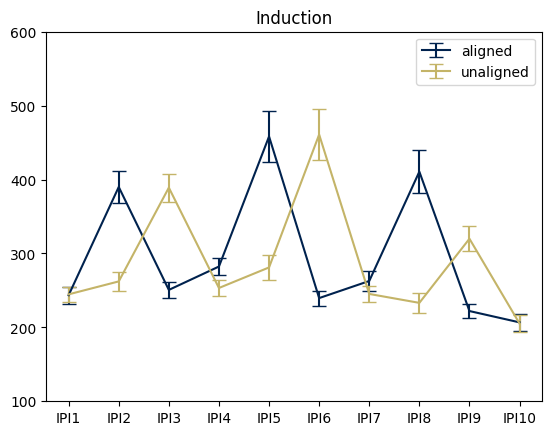

In [24]:
from natsort import index_natsorted
from matplotlib import cm
# fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.cividis
capsize = 5


data = utils.remove_error_trials(subjs_presses_seq_treatment)

data = data[data['BN'].isin(induction_blocks_treatment)]

for idx, (alignment, alignment_data) in enumerate(data.groupby('seq_type')):
    if alignment == 'control':
        continue

    finger_agg = alignment_data.groupby(['SubNum', 'IPI_Number']).agg({
        'IPI_Value': 'median'
    }).reset_index()


    finger_agg_rand = finger_agg.groupby(['IPI_Number']).agg({
                    'IPI_Value': ['mean', 'sem']
                }).reset_index()

    finger_agg_rand = finger_agg_rand.iloc[index_natsorted(finger_agg_rand['IPI_Number'])].reset_index(drop=True)
    
    #ignore IPI0
    finger_agg_rand = finger_agg_rand[finger_agg_rand['IPI_Number'] != 'IPI0']

    # plt.errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], yerr = finger_agg_rand['IPI_Value']['sem'], color = 'black' capsize = capsize, alpha = 0.2)
    plt.errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], yerr = finger_agg_rand['IPI_Value']['sem'], capsize = capsize, color=cmap(idx * 100), label = alignment)


plt.legend()
plt.title('Induction')
plt.ylim(100, 600)

    # axs[idx].set_title(f'window = {window}')


(100.0, 600.0)

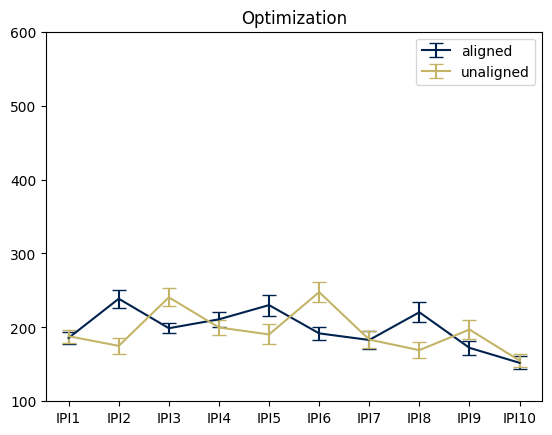

In [25]:
from natsort import index_natsorted

# fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.cividis
capsize = 5


data = utils.remove_error_trials(subjs_presses_seq_treatment)

data = data[data['BN'].isin(optimization_blocks_treatment)]

for idx, (alignment, alignment_data) in enumerate(data.groupby('seq_type')):
    if alignment == 'control':
        continue

    finger_agg = alignment_data.groupby(['SubNum', 'IPI_Number']).agg({
        'IPI_Value': 'median'
    }).reset_index()


    finger_agg_rand = finger_agg.groupby(['IPI_Number']).agg({
                    'IPI_Value': ['mean', 'sem']
                }).reset_index()

    finger_agg_rand = finger_agg_rand.iloc[index_natsorted(finger_agg_rand['IPI_Number'])].reset_index(drop=True)
    
    #ignore IPI0
    finger_agg_rand = finger_agg_rand[finger_agg_rand['IPI_Number'] != 'IPI0']

    # plt.errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], yerr = finger_agg_rand['IPI_Value']['sem'], color = 'black' capsize = capsize, alpha = 0.2)
    plt.errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], yerr = finger_agg_rand['IPI_Value']['sem'], capsize = capsize, color=cmap(idx * 100), label = alignment)


plt.legend()
plt.title('Optimization')
plt.ylim(100, 600)


    # axs[idx].set_title(f'window = {window}')


In [ ]:
subjs_seq.columns

# Mov Files

In [17]:
import os

# List all files in the path directory and subdirectories
all_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        all_files.append(os.path.join(root, file))
# all_files = os.listdir(path)

# Filter files that contain any of the subjs_ids and have a .dat extension
filtered_files = [file for file in all_files if file.endswith('.mov') and any(subj_id in file for subj_id in subjs_ids)]

In [ ]:
len(filtered_files)

In [ ]:
from collections import defaultdict

# Create a dictionary to hold lists of files for each subject
subject_files = defaultdict(list)

# Iterate over the filtered files and group them by subject ID
for file in filtered_files:
    for subj_id in subjs_ids:
        if '_' + subj_id + '_' in file:
            subject_files[subj_id].append(file)
            # break

for subj_id, files in subject_files.items():
    print(f"Subject {subj_id} has {len(files)} files")



# # Convert defaultdict to a regular dictionary for easier handling
subject_files = dict(subject_files)

In [ ]:
subject_files

In [21]:
# import glob
# import os
# import pandas as pd
# import numpy as np
# from tqdm import tqdm

# # Directory to save the separate files for each subject
# output_dir = path_misc +'output_subjects/'
# os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# def movload(fname):
#     """Loads .mov files given the path."""
#     with open(fname, 'rt') as fid:
#         trials = []
#         current_trial = []
#         num_columns = None

#         for line in fid:
#             if line.startswith('T'):
#                 # Process trial header
#                 if current_trial:
#                     trials.append(np.array(current_trial))
#                 current_trial = []
#                 num_columns = None
#             else:
#                 # Process trial data
#                 line_data = line.strip().split('\t')
#                 if num_columns is None:
#                     num_columns = len(line_data)
#                 current_trial.append([float(x) for x in line_data])
        
#         # Append the last trial
#         if current_trial:
#             trials.append(np.array(current_trial))
#     return trials

# for subj_id, files in subject_files.items():
#     # Create a separate CSV file for each subject
#     subject_output_file = os.path.join(output_dir, f'subject_{subj_id}.csv')

#     # skip if the file already exists
#     if os.path.exists(subject_output_file):
#         continue

#     if subj_id == 'LI':
#         subject_output_file = os.path.join(output_dir, f'subject_IL.csv')
#     else:
#         # Initialize the subject-specific file with headers
#         pd.DataFrame(columns=['state', 'timeReal', 'time', 'force1', 'force2', 'force3', 'force4', 'force5', 'TN', 'BN', 'SubNum']).to_csv(subject_output_file, index=False)
    
#     for file in tqdm(files):
#         filename = os.path.basename(file)
#         parts = filename.split('_')

#         if len(parts) >= 3:
#             subnum = parts[1]
#             block_number = int(parts[2].replace('.mov', ''))

#             trials = movload(file)
#             for trial_idx, trial in enumerate(trials):
#                 df = pd.DataFrame(trial, columns=['state', 'timeReal', 'time', 'force1', 'force2', 'force3', 'force4', 'force5'])
#                 df['TN'] = trial_idx + 1
#                 df['BN'] = block_number
#                 df['SubNum'] = 'IL' if subnum == 'LI' else subnum
                
#                 # Append the data to the subject-specific CSV
#                 df.to_csv(subject_output_file, mode='a', header=False, index=False)


In [22]:
output_dir = path_misc +'output_subjects/'

In [ ]:
# output_dir = path_misc +'output_subjects/'
# for idx, file in tqdm(enumerate(os.listdir(output_dir))):
#     # if idx != 5:
#     #     continue

#     if file.endswith('.csv') and not file.endswith('_seq.csv'):
#         file_path = os.path.join(output_dir, file)
#         if os.path.exists(file_path.replace('.csv', '_seq.csv')):
#             continue

#         print(file_path)
#         # Load the data from the CSV file
#         subject_data = pd.read_csv(file_path)
#         subject_data = subject_data.merge(subjs_seq, on=['SubNum', 'BN', 'TN'], how='inner')
#         rank_df = pd.DataFrame(index = subject_data.index)
#         subject_data = subject_data.sort_values(by = ['BN', 'TN'])
#         subject_data['N'] = subject_data.groupby(['BN', 'TN']).ngroup() + 1

#         subject_data_forces_exec = utils.finger_melt_Forces(subject_data)
                
#         subject_data_forces_exec.to_csv(file_path.replace('.csv', '_seq.csv'), index=False)

High RT Trial Example

In [ ]:
# subject_data_forces_exec = pd.read_csv(output_dir + 'subject_CWT_seq.csv')

In [ ]:
# x = subject_data_forces_exec[(subject_data_forces_exec['N'] == 1429)]
# # state_changes = x[x['state'].diff() != 0].index
# # print(x['board'].unique())

# fig = plt.figure(figsize=(15, 5))

# for force, data in x.groupby('Force_Number'):
#     plt.plot(data['time'], data['Force_Value'], label = force)





# # for i in range(1,6):
# #     plt.plot(x['time'], x[f'force{i}'], label = i)

# state_changes = x[x['state'].diff() != 0].index

# state_changes = x.loc[state_changes]['time'].unique()

# for change in state_changes:
#     plt.axvline(change, color = 'black')

# plt.axvline(x['IPI0'].unique(), color = 'red')
# print(x['IPI0'].unique())


# print(state_changes)


# # print(x['seq'].unique())


# plt.legend()

# plt.show()

In [ ]:
# for bn, bndata in subject_data_forces_exec.groupby('BN'):
#     for tn, tndata in bndata.groupby('TN'):
#         for force, data in tndata.groupby('Force_Number'):
#             baseline = data[data['time'] <= 15]['Force_Value'].mean()
#             # print(data)
#             subject_data_forces_exec.loc[data.index, 'Force_Value'] = data['Force_Value'] - baseline



In [ ]:
# x = subject_data_forces_exec[(subject_data_forces_exec['N'] == 1429)]
# # state_changes = x[x['state'].diff() != 0].index
# # print(x['board'].unique())

# fig = plt.figure(figsize=(15, 5))

# for force, data in x.groupby('Force_Number'):
#     plt.plot(data['time'], data['Force_Value'], label = force)





# # for i in range(1,6):
# #     plt.plot(x['time'], x[f'force{i}'], label = i)

# state_changes = x[x['state'].diff() != 0].index

# state_changes = x.loc[state_changes]['time'].unique()

# for change in state_changes:
#     plt.axvline(change, color = 'black')

# plt.axvline(x['IPI0'].unique(), color = 'red')


# print(state_changes)


# # print(x['seq'].unique())


# plt.legend()

# plt.show()

In [ ]:
# subjs_force_exec_cut = utils.cut_force(subject_data_forces_exec, 0)
# subjs_force_exec_cut_left = utils.cut_force_left(subject_data_forces_exec)
# subjs_force_exec_cut_right = utils.cut_force_right(subject_data_forces_exec)

In [ ]:
# n_samples = 300
# n_samples_left_right = 30
# aligned_cut_force = pd.DataFrame(columns=subjs_force_exec_cut.columns)
# interpolated_data = []
# x_center_interp = np.linspace(0, 1, n_samples)
# interval = x_center_interp[1] - x_center_interp[0]
# x_right_interp = np.linspace(x_center_interp[-1] + interval, x_center_interp[-1] + interval * n_samples_left_right, n_samples_left_right) - 1
# x_left_interp = np.linspace(x_center_interp[0] - interval * n_samples_left_right, x_center_interp[0] - interval, n_samples_left_right) + 1


# for sub, subdata in tqdm(subjs_force_exec_cut_left.groupby('SubNum')):
#     for bn, bndata in subdata.groupby('BN'):
#         for tn, tndata in bndata.groupby('TN'):
#             for force, data in tndata.groupby('Force_Number'):
#                 warped_force = np.interp(x_left_interp, np.linspace(0,1, len(data)), data['Force_Value'])

                
#                 interpolated_df = pd.DataFrame({
#                     'SubNum': sub,
#                     'BN': bn,
#                     'TN': tn,
#                     'Force_Number': force,
#                     'Force_Value': warped_force,
#                     'time': x_left_interp  - 1,
#                     'state': data['state'].iloc[0],
#                     'timeReal': data['timeReal'].iloc[0],
#                     'N': data['N'].iloc[0],
#                     'seqNumb': data['seqNumb'].iloc[0],
#                     'isError': data['isError'].iloc[0],
#                     'points': data['points'].iloc[0]
#                 })
#                 # new_df = pd.concat([new_df, interpolated_df])
#                 interpolated_data.append(interpolated_df)


# for sub, subdata in tqdm(subjs_force_exec_cut.groupby('SubNum')):
#     for bn, bndata in subdata.groupby('BN'):
#         for tn, tndata in bndata.groupby('TN'):
#             for force, data in tndata.groupby('Force_Number'):
#                 warped_force = np.interp(x_center_interp, np.linspace(0,1, len(data)), data['Force_Value'])

                
#                 interpolated_df = pd.DataFrame({
#                     'SubNum': sub,
#                     'BN': bn,
#                     'TN': tn,
#                     'Force_Number': force,
#                     'Force_Value': warped_force,
#                     'time': x_center_interp,
#                     'state': data['state'].iloc[0],
#                     'timeReal': data['timeReal'].iloc[0],
#                     'N': data['N'].iloc[0],
#                     'seqNumb': data['seqNumb'].iloc[0],
#                     'isError': data['isError'].iloc[0],
#                     'points': data['points'].iloc[0]
#                 })
#                 # new_df = pd.concat([new_df, interpolated_df])
#                 interpolated_data.append(interpolated_df)


# for sub, subdata in tqdm(subjs_force_exec_cut_right.groupby('SubNum')):
#     for bn, bndata in subdata.groupby('BN'):
#         for tn, tndata in bndata.groupby('TN'):
#             for force, data in tndata.groupby('Force_Number'):
#                 warped_force = np.interp(x_right_interp, np.linspace(0,1, len(data)), data['Force_Value'])
                
#                 interpolated_df = pd.DataFrame({
#                     'SubNum': sub,
#                     'BN': bn,
#                     'TN': tn,
#                     'Force_Number': force,
#                     'Force_Value': warped_force,
#                     'time': x_right_interp  + 1,
#                     'state': data['state'].iloc[0],
#                     'timeReal': data['timeReal'].iloc[0],
#                     'N': data['N'].iloc[0],
#                     'seqNumb': data['seqNumb'].iloc[0],
#                     'isError': data['isError'].iloc[0],
#                     'points': data['points'].iloc[0]
#                 })
#                 # new_df = pd.concat([new_df, interpolated_df])
#                 interpolated_data.append(interpolated_df)




# aligned_cut_force = pd.concat(interpolated_data, ignore_index=True)


In [ ]:
# plot_force(aligned_cut_force, 1429)

In [ ]:
# subject_data_forces_exec = pd.read_csv(output_dir + 'subject_CD_seq.csv')

 Low RT Trial Example

In [ ]:
# x = subject_data_forces_exec[(subject_data_forces_exec['BN'] == 86) & (subject_data_forces_exec['TN'] == 6)]
# # state_changes = x[x['state'].diff() != 0].index
# # print(x['board'].unique())

# fig = plt.figure(figsize=(15, 5))

# for force, data in x.groupby('Force_Number'):
#     plt.plot(data['time'], data['Force_Value'], label = force)





# # for i in range(1,6):
# #     plt.plot(x['time'], x[f'force{i}'], label = i)

# state_changes = x[x['state'].diff() != 0].index

# state_changes = x.loc[state_changes]['time'].unique()

# for change in state_changes:
#     plt.axvline(change, color = 'black')

# plt.axvline(x['IPI0'].unique(), color = 'red')
# print(x['IPI0'].unique())


# print(state_changes)


# # print(x['seq'].unique())


# plt.legend()

# plt.show()

In [ ]:
# x = subject_data_forces_exec[(subject_data_forces_exec['N'] == 10)]
# # state_changes = x[x['state'].diff() != 0].index
# # print(x['board'].unique())

# fig = plt.figure(figsize=(15, 5))

# for force, data in x.groupby('Force_Number'):
#     plt.plot(data['time'], data['Force_Value'], label = force)





# # for i in range(1,6):
# #     plt.plot(x['time'], x[f'force{i}'], label = i)

# state_changes = x[x['state'].diff() != 0].index

# state_changes = x.loc[state_changes]['time'].unique()

# for change in state_changes:
#     plt.axvline(change, color = 'black')

# plt.axvline(x['IPI0'].unique(), color = 'red')
# print(x['IPI0'].unique())


# print(state_changes)


# # print(x['seq'].unique())


# plt.legend()

# plt.show()

In [ ]:
# for bn, bndata in subject_data_forces_exec.groupby('BN'):
#     for tn, tndata in bndata.groupby('TN'):
#         for force, data in tndata.groupby('Force_Number'):
#             baseline = data[data['time'] <= 15]['Force_Value'].mean()
#             # print(data)
#             subject_data_forces_exec.loc[data.index, 'Force_Value'] = data['Force_Value'] - baseline



In [ ]:
# x = subject_data_forces_exec[(subject_data_forces_exec['N'] == 10)]
# # state_changes = x[x['state'].diff() != 0].index
# # print(x['board'].unique())

# fig = plt.figure(figsize=(15, 5))

# for force, data in x.groupby('Force_Number'):
#     plt.plot(data['time'], data['Force_Value'], label = force)





# # for i in range(1,6):
# #     plt.plot(x['time'], x[f'force{i}'], label = i)

# state_changes = x[x['state'].diff() != 0].index

# state_changes = x.loc[state_changes]['time'].unique()

# for change in state_changes:
#     plt.axvline(change, color = 'black')

# plt.axvline(x['IPI0'].unique(), color = 'red')


# print(state_changes)


# # print(x['seq'].unique())


# plt.legend()

# plt.show()

In [ ]:
# subjs_force_exec_cut = utils.cut_force(subject_data_forces_exec, 0)
# subjs_force_exec_cut_left = utils.cut_force_left(subject_data_forces_exec)
# subjs_force_exec_cut_right = utils.cut_force_right(subject_data_forces_exec)

In [47]:
def plot_force(subjs_force, n):
    plt.figure()
    x = subjs_force[(subjs_force['N'] == n)]
    for force, data in x.groupby('Force_Number'):
        plt.plot(data['time'], data['Force_Value'], label = force)
    state_changes = x[x['state'].diff() != 0].index
    state_changes = x.loc[state_changes]['time'].unique()
    for change in state_changes:
        plt.axvline(change, color = 'black')

    plt.ylim([-0.2, 6])

    plt.legend()
    plt.show()
    

In [ ]:
# plot_force(subjs_force_exec_cut, 10)
# plot_force(subjs_force_exec_cut_left, 10)
# plot_force(subjs_force_exec_cut_right, 10)

In [ ]:
# n_samples = 300
# n_samples_left_right = 30
# aligned_cut_force = pd.DataFrame(columns=subjs_force_exec_cut.columns)
# interpolated_data = []
# x_center_interp = np.linspace(0, 1, n_samples)
# interval = x_center_interp[1] - x_center_interp[0]
# x_right_interp = np.linspace(x_center_interp[-1] + interval, x_center_interp[-1] + interval * n_samples_left_right, n_samples_left_right) - 1
# x_left_interp = np.linspace(x_center_interp[0] - interval * n_samples_left_right, x_center_interp[0] - interval, n_samples_left_right) + 1


# for sub, subdata in tqdm(subjs_force_exec_cut_left.groupby('SubNum')):
#     for bn, bndata in subdata.groupby('BN'):
#         for tn, tndata in bndata.groupby('TN'):
#             for force, data in tndata.groupby('Force_Number'):
#                 warped_force = np.interp(x_left_interp, np.linspace(0,1, len(data)), data['Force_Value'])

                
#                 interpolated_df = pd.DataFrame({
#                     'SubNum': sub,
#                     'BN': bn,
#                     'TN': tn,
#                     'Force_Number': force,
#                     'Force_Value': warped_force,
#                     'time': x_left_interp  - 1,
#                     'state': data['state'].iloc[0],
#                     'timeReal': data['timeReal'].iloc[0],
#                     'N': data['N'].iloc[0],
#                     'seqNumb': data['seqNumb'].iloc[0],
#                     'isError': data['isError'].iloc[0],
#                     'points': data['points'].iloc[0]
#                 })
#                 # new_df = pd.concat([new_df, interpolated_df])
#                 interpolated_data.append(interpolated_df)


# for sub, subdata in tqdm(subjs_force_exec_cut.groupby('SubNum')):
#     for bn, bndata in subdata.groupby('BN'):
#         for tn, tndata in bndata.groupby('TN'):
#             for force, data in tndata.groupby('Force_Number'):
#                 warped_force = np.interp(x_center_interp, np.linspace(0,1, len(data)), data['Force_Value'])

                
#                 interpolated_df = pd.DataFrame({
#                     'SubNum': sub,
#                     'BN': bn,
#                     'TN': tn,
#                     'Force_Number': force,
#                     'Force_Value': warped_force,
#                     'time': x_center_interp,
#                     'state': data['state'].iloc[0],
#                     'timeReal': data['timeReal'].iloc[0],
#                     'N': data['N'].iloc[0],
#                     'seqNumb': data['seqNumb'].iloc[0],
#                     'isError': data['isError'].iloc[0],
#                     'points': data['points'].iloc[0]
#                 })
#                 # new_df = pd.concat([new_df, interpolated_df])
#                 interpolated_data.append(interpolated_df)


# for sub, subdata in tqdm(subjs_force_exec_cut_right.groupby('SubNum')):
#     for bn, bndata in subdata.groupby('BN'):
#         for tn, tndata in bndata.groupby('TN'):
#             for force, data in tndata.groupby('Force_Number'):
#                 warped_force = np.interp(x_right_interp, np.linspace(0,1, len(data)), data['Force_Value'])
                
#                 interpolated_df = pd.DataFrame({
#                     'SubNum': sub,
#                     'BN': bn,
#                     'TN': tn,
#                     'Force_Number': force,
#                     'Force_Value': warped_force,
#                     'time': x_right_interp  + 1,
#                     'state': data['state'].iloc[0],
#                     'timeReal': data['timeReal'].iloc[0],
#                     'N': data['N'].iloc[0],
#                     'seqNumb': data['seqNumb'].iloc[0],
#                     'isError': data['isError'].iloc[0],
#                     'points': data['points'].iloc[0]
#                 })
#                 # new_df = pd.concat([new_df, interpolated_df])
#                 interpolated_data.append(interpolated_df)




# aligned_cut_force = pd.concat(interpolated_data, ignore_index=True)


In [ ]:
# plot_force(aligned_cut_force, 10)

In [ ]:
# del interpolated_data
# del aligned_cut_force
# del subjs_force_exec_cut
# del subjs_force_exec_cut_left
# del subjs_force_exec_cut_right


In [ ]:
# output_dir = path_misc +'output_subjects/'
# for idx, file in tqdm(enumerate(os.listdir(output_dir))):
#     if file.endswith('_seq.csv') and not file.endswith('_aligned_seq.csv'):
#         file_path = os.path.join(output_dir, file)

#         if os.path.exists(file_path.replace('_seq.csv', '_aligned_seq.csv')):
#             continue

#         subj_id = file.split('_')[1].replace('.csv', '')
#         print(subj_id)

#         if subj_id in discard_subjs:
#             continue

#         print(file_path)
#         # Load the data from the CSV file
#         subject_data_forces_exec = pd.read_csv(file_path)

#         # baseline correction
#         for bn, bndata in subject_data_forces_exec.groupby('BN'):
#             for tn, tndata in bndata.groupby('TN'):
#                 for force, data in tndata.groupby('Force_Number'):
#                     baseline = data[data['time'] <= 15]['Force_Value'].mean()
#                     subject_data_forces_exec.loc[data.index, 'Force_Value'] = data['Force_Value'] - baseline
        
#         subjs_force_exec_cut = utils.cut_force(subject_data_forces_exec, 0)
#         subjs_force_exec_cut_left = utils.cut_force_left(subject_data_forces_exec)
#         subjs_force_exec_cut_right = utils.cut_force_right(subject_data_forces_exec)

#         del subject_data_forces_exec


#         # aligning the forces
#         n_samples = 300
#         n_samples_left_right = 30
#         aligned_cut_force = pd.DataFrame(columns=subjs_force_exec_cut.columns)
#         interpolated_data = []
#         x_center_interp = np.linspace(0, 1, n_samples)
#         interval = x_center_interp[1] - x_center_interp[0]
#         x_right_interp = np.linspace(x_center_interp[-1] + interval, x_center_interp[-1] + interval * n_samples_left_right, n_samples_left_right) - 1
#         x_left_interp = np.linspace(x_center_interp[0] - interval * n_samples_left_right, x_center_interp[0] - interval, n_samples_left_right) + 1


#         for sub, subdata in tqdm(subjs_force_exec_cut_left.groupby('SubNum')):
#             for bn, bndata in subdata.groupby('BN'):
#                 for tn, tndata in bndata.groupby('TN'):
#                     for force, data in tndata.groupby('Force_Number'):
#                         warped_force = np.interp(x_left_interp, np.linspace(0,1, len(data)), data['Force_Value'])

                        
#                         interpolated_df = pd.DataFrame({
#                             'SubNum': sub,
#                             'BN': bn,
#                             'TN': tn,
#                             'Force_Number': force,
#                             'Force_Value': warped_force,
#                             'time': x_left_interp  - 1,
#                             'state': data['state'].iloc[0],
#                             'timeReal': data['timeReal'].iloc[0],
#                             'N': data['N'].iloc[0],
#                             'seqNumb': data['seqNumb'].iloc[0],
#                             'isError': data['isError'].iloc[0],
#                             'points': data['points'].iloc[0]
#                         })
#                         # new_df = pd.concat([new_df, interpolated_df])
#                         interpolated_data.append(interpolated_df)

#         del subjs_force_exec_cut_left

#         for sub, subdata in tqdm(subjs_force_exec_cut.groupby('SubNum')):
#             for bn, bndata in subdata.groupby('BN'):
#                 for tn, tndata in bndata.groupby('TN'):
#                     for force, data in tndata.groupby('Force_Number'):
#                         warped_force = np.interp(x_center_interp, np.linspace(0,1, len(data)), data['Force_Value'])

                        
#                         interpolated_df = pd.DataFrame({
#                             'SubNum': sub,
#                             'BN': bn,
#                             'TN': tn,
#                             'Force_Number': force,
#                             'Force_Value': warped_force,
#                             'time': x_center_interp,
#                             'state': data['state'].iloc[0],
#                             'timeReal': data['timeReal'].iloc[0],
#                             'N': data['N'].iloc[0],
#                             'seqNumb': data['seqNumb'].iloc[0],
#                             'isError': data['isError'].iloc[0],
#                             'points': data['points'].iloc[0]
#                         })
#                         # new_df = pd.concat([new_df, interpolated_df])
#                         interpolated_data.append(interpolated_df)


#         del subjs_force_exec_cut

#         for sub, subdata in tqdm(subjs_force_exec_cut_right.groupby('SubNum')):
#             for bn, bndata in subdata.groupby('BN'):
#                 for tn, tndata in bndata.groupby('TN'):
#                     for force, data in tndata.groupby('Force_Number'):
#                         warped_force = np.interp(x_right_interp, np.linspace(0,1, len(data)), data['Force_Value'])
                        
#                         interpolated_df = pd.DataFrame({
#                             'SubNum': sub,
#                             'BN': bn,
#                             'TN': tn,
#                             'Force_Number': force,
#                             'Force_Value': warped_force,
#                             'time': x_right_interp  + 1,
#                             'state': data['state'].iloc[0],
#                             'timeReal': data['timeReal'].iloc[0],
#                             'N': data['N'].iloc[0],
#                             'seqNumb': data['seqNumb'].iloc[0],
#                             'isError': data['isError'].iloc[0],
#                             'points': data['points'].iloc[0]
#                         })
#                         # new_df = pd.concat([new_df, interpolated_df])
#                         interpolated_data.append(interpolated_df)


#         del subjs_force_exec_cut_right

#         aligned_cut_force = pd.concat(interpolated_data, ignore_index=True)
#         del interpolated_data
#         aligned_cut_force.to_csv(file_path.replace('_seq.csv', '_aligned_seq.csv'), index=False)
#         del aligned_cut_force

        

In [ ]:
# from sklearn.decomposition import PCA
# forces = [1,2,3,4,5]
# import pickle

# output_dir = path_misc +'output_subjects/'

# # fig, axs = plt.subplots(38, 7, figsize = (40, 100))

# num_sequences = 4
# num_cores = mp.cpu_count()

# reduced_forces_correct_dict = {}
# reduced_forces_all_dict = {}
# components = {}

# n_dim_reduction = 30

# subnum = 0
# for idx, file in tqdm(enumerate(os.listdir(output_dir))):
#     # if subnum != 0:
#     #     continue

#     if file.endswith('_aligned_seq.csv'):
#         file_path = os.path.join(output_dir, file)
#         print(file_path)
#         aligned_cut_force = pd.read_csv(file_path)

#         sub_id = file.split('_')[1]
#         if sub_id in control_subjs:
#             aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_topimization_blocks_control)]
#         else:
#             aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_optimization_blocks_treatment)]
             

#         for seqnum, seq_data in aligned_cut_force_optimization.groupby('seqNumb'):
#             seq_data_correct = utils.remove_error_trials(seq_data)
#             pivot_data = seq_data_correct.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
#             pca = PCA()
#             pca.fit(pivot_data)
#             components[subnum, seqnum] = pca.components_[:n_dim_reduction]

#             explained_variance = pca.explained_variance_ratio_
#             dim_reduced = np.argmax(np.cumsum(explained_variance) >= 0.9)
#             # print(dim_reduced)
#             reduced_forces_correct_dict[subnum, seqnum] = pca.transform(pivot_data)[:,:n_dim_reduction]
#             pivot_data = seq_data.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').fillna(0).to_numpy()
#             reduced_forces_all_dict[subnum, seqnum] = pca.transform(pivot_data)[:,:n_dim_reduction]




#             # ax_ind = (subnum, seqnum - 1)
#             # axs[ax_ind].plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker = 'o', linestyle = '--')
#             # axs[ax_ind].set_title(f'Subject {subnum} Sequence {seqnum}')
#             # axs[ax_ind].set_xlabel('Principal Component')
#             # axs[ax_ind].set_ylabel('Explained Variance')

#         subnum += 1
        

            

In [ ]:
# np.save(path_misc + 'reduced_forces_correct_dict.npy', reduced_forces_correct_dict)
# np.save(path_misc + 'reduced_forces_all_dict.npy', reduced_forces_all_dict)
# np.save(path_misc + 'components.npy', components)

In [21]:
reduced_forces_all_dict = np.load(path_misc + 'reduced_forces_all_dict.npy', allow_pickle=True).item()
reduced_forces_correct_dict = np.load(path_misc + 'reduced_forces_correct_dict.npy', allow_pickle=True).item()
components = np.load(path_misc + 'components.npy', allow_pickle=True).item()

In [ ]:
from sklearn.decomposition import PCA
forces = [1,2,3,4,5]
import pickle

output_dir = path_misc +'output_subjects/'


num_cores = mp.cpu_count()

subnum_to_subid = {}


subnum = 0
for idx, file in tqdm(enumerate(os.listdir(output_dir))):


    if file.endswith('_aligned_seq.csv'):
        file_path = os.path.join(output_dir, file)
        # print(file_path)


        sub_id = file.split('_')[1]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]

        subnum_to_subid[subnum] = sub_id


        subnum += 1
        

            

In [ ]:
from sklearn.decomposition import PCA
forces = [1,2,3,4,5]
import pickle

output_dir = path_misc +'output_subjects/'

fig, axs = plt.subplots(38, 7, figsize = (40, 200))

num_cores = mp.cpu_count()

component_rank = 0
cmap = cm.Pastel1
subnum = 0
for idx, file in tqdm(enumerate(os.listdir(output_dir))):
    # if subnum != 0:
    #     continue

    if file.endswith('_aligned_seq.csv'):
        file_path = os.path.join(output_dir, file)
        # print(file_path)
        aligned_cut_force = pd.read_csv(file_path)

        sub_id = file.split('_')[1]
        if sub_id in control_subjs:
            aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_topimization_blocks_control)]
            group = 'control'
        else:
            aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_optimization_blocks_treatment)]
            group = sub_group[sub_id]

        for seqnum, seq_data in aligned_cut_force_optimization.groupby('seqNumb'):
            seq_data_correct = utils.remove_error_trials(seq_data)
            pivot_data = seq_data_correct.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
            mean_forces = np.mean(pivot_data, axis = 0).reshape(len(fingers), n_samples_left_right * 2 + n_samples)

            forces = components[subnum, seqnum][component_rank].reshape(len(fingers), n_samples_left_right * 2 + n_samples)

            ax_ind = (subnum, seqnum - 1)

            for force_ind, force in enumerate(mean_forces):
                axs[ax_ind].plot(force, linestyle = '--', color = cmap(force_ind))

            for force_ind, force in enumerate(forces):
                axs[ax_ind].plot(force * 10, label = f'force {force_ind + 1}', color = cmap(force_ind))
            
            axs[ax_ind].set_title(f'Subject {subnum} Sequence {seqnum} Group {group}')
            axs[ax_ind].set_xlabel('Time')
            axs[ax_ind].set_ylabel('Force')
            axs[ax_ind].legend()

        subnum += 1
        

            

# Dissimilarity Analysis:

In [ ]:
fig, axs = plt.subplots(38, 7, figsize = (40, 200))
for (subnum, seqnum), data in reduced_forces_correct_dict.items():
    # if subnum != 0:
    #     continue
    distances = pd.DataFrame(index = range(data.shape[0]), columns = range(data.shape[0]), dtype = float)
    for i in tqdm(range(data.shape[0]), desc = f'Processing Subject {subnum} Sequence {seqnum}'):
        for j in range(data.shape[0]):
            distances.loc[i, j] = np.linalg.norm(data[i] - data[j])

    ax_ind = (subnum, seqnum - 1)
    sub_id = subnum_to_subid[subnum]
    if sub_id in control_subjs:
        group = 'control'
    else:
        group = sub_group[sub_id]
    sns.heatmap(distances, ax = axs[ax_ind], cmap = 'coolwarm')
    axs[ax_ind].set_title(f'Subject {subnum} Sequence {seqnum} Group {group}')


In [798]:
#zero out incorrect trials forces
for (subnum, seqnum), data in reduced_forces_all_dict.items():
    for i in range(data.shape[0]):
        if i not in correct_trials[subnum, seqnum]:
            data[i] = np.zeros(data.shape[1])

In [ ]:
# distances_all = pd.DataFrame(columns = pd.MultiIndex.from_product([
#     specific_sequences, ['G1', 'G2', 'control'], subjs_ids
# ], names = ['Sequence', 'Group', 'Subject']), dtype = float)


# for (subnum, seqnum), data in reduced_forces_all_dict.items():
#     # if subnum > 10:
#     #     continue
#     distances = pd.DataFrame(index = range(data.shape[0]), columns = range(data.shape[0]), dtype = float)
#     for i in tqdm(range(data.shape[0]), desc = f'Processing Subject {subnum} Sequence {seqnum}'):
#         for j in range(data.shape[0]):
#             distances.loc[i, j] = np.linalg.norm(data[i] - data[j])

#     ax_ind = (subnum, seqnum - 1)
#     sub_id = subnum_to_subid[subnum]
#     if sub_id in control_subjs:
#         group = 'control'
#     else:
#         group = sub_group[sub_id]

#     flattened_distances = pd.Series(distances.to_numpy().flatten())
#     distances_all[seqnum, group, sub_id] = flattened_distances



In [801]:
distances_all.to_csv(path_misc + 'distances_all.csv')

In [231]:
distances_all = pd.read_csv(path_misc + 'distances_all.csv', header = [0,1,2], index_col = 0)

In [ ]:
distances_all

In [803]:
corrs = distances_all.corr()
corrs = corrs.dropna(axis = 0, how = 'all').dropna(axis = 1, how = 'all')
subjects = corrs.columns.get_level_values(2).unique()
groups = corrs.columns.get_level_values(1).unique()
sequences = corrs.columns.get_level_values(0).unique()

# Define color palettes for each level
subject_colors = sns.color_palette("Set3", len(subjects))
group_colors = sns.color_palette("Pastel1", len(groups))
sequence_colors = sns.color_palette("Dark2", len(sequences))

# Create color mappings
subject_color_map = dict(zip(subjects, subject_colors))
group_color_map = dict(zip(groups, group_colors))
sequence_color_map = dict(zip(sequences, sequence_colors))

# Map colors to each level of the multi-index
sequence_colors_mapped = corrs.columns.get_level_values(0).map(sequence_color_map)
group_colors_mapped = corrs.columns.get_level_values(1).map(group_color_map)
subject_colors_mapped = corrs.columns.get_level_values(2).map(subject_color_map)


# combined color mappings for each level to a multi-level df same as x
col_colors = pd.DataFrame(
    {
        "Sequence": sequence_colors_mapped,
        "Group": group_colors_mapped,
        "Subject": subject_colors_mapped,
    },
    index=corrs.columns,
)


In [ ]:
sns.clustermap(corrs, cmap = 'coolwarm', figsize = (40, 40), vmin = 0, vmax = 0.3, col_colors=col_colors, row_colors=col_colors)

In [ ]:
corrs

In [ ]:
# total variance of data in corrs matrix
idx = pd.IndexSlice
total_variance = np.var(corrs.to_numpy()[np.triu_indices_from(corrs.to_numpy())])
print(total_variance)
# print(corrs.to_numpy().mean())


within_seq_values = []
between_seq_values = []
temp = np.array([])
temp_corrs = corrs.copy()
for seq in sequences.unique():
    seq_corrs_across = temp_corrs.loc[idx[seq, :, :], idx[:, :, :]]
    seq_corrs_within = temp_corrs.loc[idx[seq, :, :], idx[seq, :, :]]
    # remove seq_corrs_within from seq_corrs_across
    seq_corrs_across = seq_corrs_across.drop(labels = seq_corrs_within.columns, axis = 1)
    seq_corrs_within = seq_corrs_within.to_numpy()

    within_seq_values = np.append(within_seq_values, seq_corrs_within[np.triu_indices_from(seq_corrs_within)])
    between_seq_values = np.append(between_seq_values, seq_corrs_across.to_numpy().flatten())

    #drop seq from temp_corrs
    temp_corrs = temp_corrs.drop(labels = seq, axis = 1, level = 0)


seq_variance = np.var([within_seq_values.mean(), between_seq_values.mean()])

    
within_group_values = []
between_group_values = []
temp_corrs = corrs.copy()
for group in groups.unique():
    group_corss_across = temp_corrs.loc[idx[:, group, :], idx[:, :, :]]
    group_corrs_within = temp_corrs.loc[idx[:, group, :], idx[:, group, :]]
    group_corss_across = group_corss_across.drop(labels = group_corrs_within.columns, axis = 1)
    group_corrs_within = group_corrs_within.to_numpy()

    within_group_values = np.append(within_group_values, group_corrs_within[np.triu_indices_from(group_corrs_within)])
    between_group_values = np.append(between_group_values, group_corss_across.to_numpy().flatten())


    #drop group from temp_corrs
    temp_corrs = temp_corrs.drop(labels = group, axis = 1, level = 1)


group_variance = np.var([within_group_values.mean(), between_group_values.mean()])



within_subj_values = []
between_subj_values = []
temp_corrs = corrs.copy()
for subj in subjects.unique():
    subj_corss_across = temp_corrs.loc[idx[:, :, subj], idx[:, :, :]]
    subj_corrs_within = temp_corrs.loc[idx[:, :, subj], idx[:, :, subj]]
    subj_corss_across = subj_corss_across.drop(labels = subj_corrs_within.columns, axis = 1)
    subj_corrs_within = subj_corrs_within.to_numpy()

    within_subj_values = np.append(within_subj_values, subj_corrs_within[np.triu_indices_from(subj_corrs_within)])
    between_subj_values = np.append(between_subj_values, subj_corss_across.to_numpy().flatten())

    #drop subj from temp_corrs
    temp_corrs = temp_corrs.drop(labels = subj, axis = 1, level = 2)


subj_variance = np.var([within_subj_values.mean(), between_subj_values.mean()])


print(seq_variance, group_variance, subj_variance)
print(f'seq: within {within_seq_values.mean()} between {between_seq_values.mean()}')
print(f'group: within {within_group_values.mean()} between {between_group_values.mean()}')
print(f'subj: within {within_subj_values.mean()} between {between_subj_values.mean()}')




In [618]:
# extract upper triangle of the correlation matrix with their correspoding index and column names
upper_triangle = corrs.to_numpy()[np.triu_indices_from(corrs)]
upper_triangle_index = corrs.index.to_numpy()[np.triu_indices_from(corrs)[0]]
upper_triangle_columns = corrs.columns.to_numpy()[np.triu_indices_from(corrs)[1]]

rows = []
for i in range(len(upper_triangle)):
    index = upper_triangle_index[i]
    column = upper_triangle_columns[i]
    same_seq = index[0] == column[0]
    same_group = index[1] == column[1]
    same_subj = index[2] == column[2]
    row = {
        'same_seq': same_seq,
        'same_group': same_group,
        'same_subj': same_subj,
        'corr': upper_triangle[i]
    }
    rows.append(row)
data = pd.DataFrame(rows)

# remove rows with same_seq, same_group, same_subj all true
data = data[~(data['same_seq'] & data['same_group'] & data['same_subj'])]
    

In [ ]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols('corr ~ same_seq + same_group + same_subj', data = data).fit()

print(sm.stats.anova_lm(model))

In [ ]:
seq_corrs.shape

In [ ]:
from scipy.stats import ttest_rel
num_subjects = 38
idx = pd.IndexSlice

for seqnum in specific_sequences:
    df = pd.DataFrame(columns = ['SubNum', 'within', 'between'])
    seq_corrs = corrs.loc[idx[seqnum, :, :], idx[seqnum, :, :]]
    for subid in corrs.columns.get_level_values(2).unique():
        
        if subid in control_subjs:
            group = 'control'
        else:
            group = sub_group[subid]

        within_group = seq_corrs.loc[idx[:, group, subid], idx[:, group, :]]
        between_group = seq_corrs.loc[idx[:, group, subid], idx[:, :, :]]
        between_group = between_group.drop(labels = within_group.columns, axis = 1)
        within_group = within_group.drop(labels = within_group.index, axis = 1)

        within_group = within_group.to_numpy().flatten()
        between_group = between_group.to_numpy().flatten()
        df.loc[len(df)] = [subid, within_group.mean(), between_group.mean()]

    
    if seqnum in seq_dict['G1']['aligned']:
        seq_alignment = 'G1 aligned'
    elif seqnum in seq_dict['G2']['aligned']:
        seq_alignment = 'G2 aligned'
    else:
        seq_alignment = ''
    
    #t-test
    print(f'Seq {seqnum} {seq_alignment}')
    print(ttest_rel(df['within'], df['between'], alternative = 'two-sided'))
        




In [ ]:
from scipy.stats import ttest_rel
num_subjects = 38
idx = pd.IndexSlice

df = pd.DataFrame(columns = ['SubNum', 'within', 'between'])


for subid in corrs.columns.get_level_values(2).unique():
    
    if subid in control_subjs:
        group = 'control'
    else:
        group = sub_group[subid]
        

    within_group = corrs.loc[idx[:, group, subid], idx[:, group, :]]
    between_group = corrs.loc[idx[:, group, subid], idx[:, :, :]]
    between_group = between_group.drop(labels = within_group.columns, axis = 1)
    within_group = within_group.drop(labels = within_group.index, axis = 1)

    within_group = within_group.to_numpy().flatten()
    between_group = between_group.to_numpy().flatten()
    df.loc[len(df)] = [subid, within_group.mean(), between_group.mean()]



#t-test
print(ttest_rel(df['within'], df['between'], alternative = 'two-sided'))
        




In [ ]:
from scipy.stats import ttest_rel
num_subjects = 38
idx = pd.IndexSlice

df = pd.DataFrame(columns = ['SubNum', 'within', 'between'])


for subid in corrs.columns.get_level_values(2).unique():
    
    if subid in control_subjs:
        group = 'control'
    else:
        group = sub_group[subid]

    within_seq_values = []
    between_seq_values = []
    for seqnum in specific_sequences:
        within_group = corrs.loc[idx[seqnum, :, subid], idx[seqnum, :, :]]
        between_group = corrs.loc[idx[seqnum, :, subid], idx[:, :, :]]
        between_group = between_group.drop(labels = within_group.columns, axis = 1)
        within_group = within_group.drop(labels = within_group.index, axis = 1)
        within_seq_values = np.append(within_seq_values, within_group.to_numpy().flatten())
        between_seq_values = np.append(between_seq_values, between_group.to_numpy().flatten())

    df.loc[len(df)] = [subid, within_seq_values.mean(), between_seq_values.mean()]


#t-test
print(ttest_rel(df['within'], df['between'], alternative = 'greater'))


    




In [ ]:
within_group

# Group Space Analysis:

In [ ]:
# from sklearn.decomposition import PCA
# forces = [1,2,3,4,5]
# import pickle

# output_dir = path_misc +'output_subjects/'

# for seqnum in specific_sequences:
#     seq_cut_force = []
#     for idx, file in tqdm(enumerate(os.listdir(output_dir))):
#         # if subnum != 0:
#         #     continue

#         if file.endswith('_aligned_seq.csv'):
#             file_path = os.path.join(output_dir, file)
#             # print(file_path)
#             aligned_cut_force = pd.read_csv(file_path)
#             aligned_cut_force = aligned_cut_force[aligned_cut_force['seqNumb'] == seqnum]

#             sub_id = file.split('_')[1]
#             if sub_id in control_subjs:
#                 aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_topimization_blocks_control)]
#                 group = 'control'
#             else:
#                 aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_optimization_blocks_treatment)]
#                 group = sub_group[sub_id]
            
#             seq_cut_force.append(aligned_cut_force_optimization)
#     seq_cut_force = pd.concat(seq_cut_force, axis = 0)
#     seq_cut_force.to_csv(path_misc + f'seq_{seqnum}_aligned_memory_optimization.csv', index = False)


        

In [ ]:
from sklearn.decomposition import PCA
forces = [1,2,3,4,5]
import pickle
from matplotlib import cm 

output_dir = path_misc +'output_subjects/'

reduced_forces_group_correct_dict = {}
reduced_forces_group_all_dict = {}
components_group = {}
pca_group = {}
n_dim_reduction = 40
pivot_datas = defaultdict(list)

cmap = cm.Pastel1
subnum = 0

for seqnum in specific_sequences:

    seq_file = path_misc + f'seq_{seqnum}_aligned_memory_optimization.csv'
    seq_data = pd.read_csv(seq_file)
    seq_data_correct = utils.remove_error_trials(seq_data)

    pivot_data = seq_data_correct.pivot_table(index = ['SubNum', 'N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()

    pca = PCA()
    pca.fit(pivot_data)
    components_group[seqnum] = pca.components_[:n_dim_reduction]
    pca_group[seqnum] = pca
    explained_variance = pca.explained_variance_ratio_
    dim_reduced = np.argmax(np.cumsum(explained_variance) >= 0.9)
    # print(dim_reduced)


for idx, file in tqdm(enumerate(os.listdir(output_dir))):
    # if subnum != 0:
    #     continue
    if file.endswith('_aligned_seq.csv'):
        file_path = os.path.join(output_dir, file)
        aligned_cut_force = pd.read_csv(file_path)

        sub_id = file.split('_')[1]
        if sub_id in control_subjs:
            aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_topimization_blocks_control)]
            group = 'control'
        else:
            aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_optimization_blocks_treatment)]
            group = sub_group[sub_id]
        
        for seqnum, seq_data in aligned_cut_force_optimization.groupby('seqNumb'):
            seq_data_correct = utils.remove_error_trials(seq_data)
            pivot_data = seq_data_correct.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
            reduced_forces_group_correct_dict[subnum, seqnum] = pca_group[seqnum].transform(pivot_data)[:,:n_dim_reduction]
            pivot_data = seq_data.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
            reduced_forces_group_all_dict[subnum, seqnum] = pca_group[seqnum].transform(pivot_data)[:,:n_dim_reduction]


        subnum += 1


        

In [ ]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
num_subjects = 38

for seqnum in specific_sequences:
    fig = go.Figure()
    for subnum in range(num_subjects):
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros_like(forces)
        for i in range(n_dim_reduction):
            smoothed_states[:,i] = np.convolve(forces[:,i], kernel, mode = 'same')
        
        color = np.arange(len(forces))

        fig.add_trace(go.Scatter3d(x=smoothed_states[:,0], y=smoothed_states[:,1], z=smoothed_states[:,2], mode='lines', line=dict(color=color, colorscale='Viridis', width=1, showscale = True)))

    fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    width=800,
                    height=800,
                    margin=dict(l=100, r=100, b = 100, t=100),
                    title_text = f'Seq {seqnum}')
    fig.show()




In [ ]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
num_subjects = 38
cmap = cm.Pastel1

for seqnum in specific_sequences:
    fig = go.Figure()
    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros((forces.shape[0] - window_size + 1, n_dim_reduction))
        for i in range(n_dim_reduction):
            smoothed_states[:,i] = np.convolve(forces[:,i], kernel, mode = 'valid')


        #determine color based on group 
        if group == 'control':
            color = 'black'
        else:
            color = (lambda group: cmap(0) if group == 'G1' else cmap(1))(group)
            color = (lambda group: 'red' if group == 'G1' else 'blue')(group)

        
        # plot start and end points in the first 3 principal components
        fig.add_trace(go.Scatter3d(x=[smoothed_states[0,0]], y=[smoothed_states[0,1]], z=[smoothed_states[0,2]], mode='markers', name = f'{sub_id}({group})', legendgroup=sub_id,
                                    marker=dict(size=10, color=color, opacity=0.3, symbol='circle')))
        fig.add_trace(go.Scatter3d(x=[smoothed_states[-1,0]], y=[smoothed_states[-1,1]], z=[smoothed_states[-1,2]], mode='markers', showlegend=False, legendgroup=sub_id,
                                   marker=dict(size=10, color=color, opacity=0.3, symbol = 'diamond')))
        
        # fig.add_trace(go.Scatter3d(x=smoothed_states[:,0], y=smoothed_states[:,1], z=smoothed_states[:,2], showlegend=False, mode='lines', line=dict(color=color, width=1)))


    
        
        

    fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    width=800,
                    height=800,
                    margin=dict(l=100, r=100, b = 100, t=100),
                    title_text = f'Seq {seqnum}', 
                    showlegend = True)
    fig.show()



In [ ]:
for (subnum, seqnum), forces in reduced_forces_group_all_dict.items():
    print(subnum, seqnum, forces.shape)

In [ ]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
num_subjects = 38
cmap = cm.Pastel1

for seqnum in specific_sequences:
    fig = go.Figure()
    starting_points = defaultdict(list)
    ending_points = defaultdict(list)
    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros((forces.shape[0] - window_size + 1, n_dim_reduction))
        for i in range(n_dim_reduction):
            smoothed_states[:,i] = np.convolve(forces[:,i], kernel, mode = 'valid')

        starting_points[group].append(smoothed_states[0])
        ending_points[group].append(smoothed_states[-1])

    for group in starting_points:
        starts = np.array(starting_points[group])
        ends = np.array(ending_points[group])
        agg_start = np.mean(starts, axis = 0)
        agg_end = np.mean(ends, axis = 0)

        #between subjects standard error
        agg_start_std = np.std(starts, axis = 0)
        agg_end_std = np.std(ends, axis = 0)


        #determine color based on group 
        if group == 'control':
            color = 'black'
        else:
            color = (lambda group: cmap(0) if group == 'G1' else cmap(1))(group)
            color = (lambda group: 'red' if group == 'G1' else 'blue')(group)


        fig.add_trace(go.Scatter3d(x=[agg_start[0]], y=[agg_start[1]], z=[agg_start[2]], mode='markers', name = f'{group} start', legendgroup=group,
                                    marker=dict(size=10, color=color, opacity=0.3, symbol='circle')))
        fig.add_trace(go.Scatter3d(x=[agg_end[0]], y=[agg_end[1]], z=[agg_end[2]], mode='markers', name = f'{group} end', legendgroup=group,
                                    marker=dict(size=10, color=color, opacity=0.3, symbol='diamond'))
        )

    if seqnum in seq_dict['G1']['aligned']:
        title = f'Seq {seqnum} Group 1 Aligned'
    elif seqnum in seq_dict['G2']['aligned']:
        title = f'Seq {seqnum} Group 2 Aligned'
    else:
        title = f'Seq {seqnum}'
    

    fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    width=800,
                    height=800,
                    margin=dict(l=100, r=100, b = 100, t=100),
                    title_text = title, 
                    showlegend = True)


    fig.show()






In [ ]:
import numpy as np
import plotly.graph_objects as go
from collections import defaultdict
from matplotlib import cm

def create_ellipsoid(center, radii, color, legendgroup, opacity=0.05):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = radii[0] * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radii[1] * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v)) + center[2]
    return go.Surface(x=x, y=y, z=z, colorscale=[[0, color], [1, color]], opacity=opacity, showscale=False,
                      legendgroup=legendgroup, showlegend=False)

num_subjects = 38
cmap = cm.Pastel1

for seqnum in specific_sequences:
    fig = go.Figure()
    starting_points = defaultdict(list)
    ending_points = defaultdict(list)

    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros((forces.shape[0] - window_size + 1, n_dim_reduction))
        for i in range(n_dim_reduction):
            smoothed_states[:, i] = np.convolve(forces[:, i], kernel, mode='valid')

        starting_points[group].append(smoothed_states[0])
        ending_points[group].append(smoothed_states[-1])

    for group in starting_points:
        starts = np.array(starting_points[group])
        ends = np.array(ending_points[group])
        agg_start = np.mean(starts, axis=0)
        agg_end = np.mean(ends, axis=0)

        # Between-subjects standard error
        agg_start_std = np.std(starts, axis=0)
        agg_end_std = np.std(ends, axis=0)

        # Determine color based on group 
        if group == 'control':
            color = 'black'
        else:
            color = 'red' if group == 'G1' else 'blue'

        # Add ellipsoid for start
        fig.add_trace(create_ellipsoid(center=agg_start, radii=agg_start_std, color=color, legendgroup=group))
        # Add ellipsoid for end
        fig.add_trace(create_ellipsoid(center=agg_end, radii=agg_end_std, color=color, legendgroup=group))

        # Add start and end points
        fig.add_trace(go.Scatter3d(
            x=[agg_start[0]], y=[agg_start[1]], z=[agg_start[2]],
            mode='markers', name=f'{group} start', legendgroup=group,
            marker=dict(size=10, color=color, opacity=1.0, symbol='circle')))
        fig.add_trace(go.Scatter3d(
            x=[agg_end[0]], y=[agg_end[1]], z=[agg_end[2]],
            mode='markers', name=f'{group} end', legendgroup=group,
            marker=dict(size=10, color=color, opacity=1.0, symbol='diamond')))

    if seqnum in seq_dict['G1']['aligned']:
        title = f'Seq {seqnum} Group 1 Aligned'
    elif seqnum in seq_dict['G2']['aligned']:
        title = f'Seq {seqnum} Group 2 Aligned'
    else:
        title = f'Seq {seqnum}'

    fig.update_layout(scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'),
        width=800,
        height=800,
        margin=dict(l=100, r=100, b=100, t=100),
        title_text=title,
        showlegend=True)

    fig.show()


In [ ]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
from scipy.stats import ttest_1samp
from scipy.stats import t

num_subjects = 38
cmap = cm.cividis

for seqnum in specific_sequences:
    fig = go.Figure()
    starting_points = defaultdict(list)
    ending_points = defaultdict(list)
    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros((forces.shape[0] - window_size + 1, n_dim_reduction))
        for i in range(n_dim_reduction):
            smoothed_states[:,i] = np.convolve(forces[:,i], kernel, mode = 'valid')

        starting_points[group].append(smoothed_states[0])
        ending_points[group].append(smoothed_states[-1])

    fig = plt.figure()
    print(f'Seq {seqnum}')
    for group in starting_points:
        starts = np.array(starting_points[group])
        ends = np.array(ending_points[group])
        agg_start = np.mean(starts, axis = 0)
        agg_end = np.mean(ends, axis = 0)

        end_start_diff = ends - starts
        
        #within group correlations between end_start_diff
        corr = np.corrcoef(end_start_diff)
        corrs = corr[np.triu_indices(corr.shape[0], k = 1)]

        if group == 'control':
            color = 'black'
        else:
            color = (lambda group: cmap(0) if group == 'G1' else cmap(200))(group)


        # sns.histplot(corrs,  label = group, alpha = 0.5, stat = 'probability')
        plt.hist(corrs, bins = 20, alpha = 0.3, label = group, density = True, color = color)
        dof = end_start_diff.shape[0] - 2 
        mean_corr = np.mean(corrs)
        std_dev = np.std(corrs, ddof = 1)
        t_stat = mean_corr / (std_dev / np.sqrt(len(corrs)))
        p_val = t.sf(np.abs(t_stat), dof) * 2

        print(f'{group} mean_corr: {mean_corr} pval: {p_val}')

    if seqnum in seq_dict['G1']['aligned']:
        title = f'Seq {seqnum} Group 1 Aligned'
    elif seqnum in seq_dict['G2']['aligned']:
        title = f'Seq {seqnum} Group 2 Aligned'
    else:
        title = f'Seq {seqnum}'

    plt.title(title)

    plt.legend()







In [ ]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
from scipy.stats import ttest_1samp
num_subjects = 38
cmap = cm.cividis

for seqnum in specific_sequences:
    fig = go.Figure()
    starting_points = defaultdict(list)
    ending_points = defaultdict(list)
    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros((forces.shape[0] - window_size + 1, n_dim_reduction))
        for i in range(n_dim_reduction):
            smoothed_states[:,i] = np.convolve(forces[:,i], kernel, mode = 'valid')

        starting_points[group].append(smoothed_states[0])
        ending_points[group].append(smoothed_states[-1])

    fig = plt.figure()
    print(f'Seq {seqnum}')
    end_start_diffs = {}
    for group in starting_points:
        starts = np.array(starting_points[group])
        ends = np.array(ending_points[group])
        agg_start = np.mean(starts, axis = 0)
        agg_end = np.mean(ends, axis = 0)

        end_start_diff = ends - starts
        end_start_diffs[group] = end_start_diff


    #between group correlations between end_start_diff
    clr_idx = 0
    for group1 in end_start_diffs:
        for group2 in end_start_diffs:
            if group1 == group2 or (group2 > group1):
                continue
            corrs = np.corrcoef(end_start_diffs[group1], end_start_diffs[group2])
            # choose elements belonging to different groups
            corrs = corrs[:len(end_start_diffs[group1]), len(end_start_diffs[group1]):]
            corrs = corrs.flatten()

            plt.hist(corrs, bins = 20, alpha = 0.2, label = f'{group1} vs {group2}', density = True, color = cmap(clr_idx))
            clr_idx += 150
            print(f'{group1} vs {group2} mean_corr: {corrs.mean()} pval: {ttest_1samp(corrs, 0)[1]}')
    
    if seqnum in seq_dict['G1']['aligned']:
        title = f'Seq {seqnum} Group 1 Aligned'
    elif seqnum in seq_dict['G2']['aligned']:
        title = f'Seq {seqnum} Group 2 Aligned'
    else:
        title = f'Seq {seqnum}'
    plt.title(title)
    plt.legend()

        









In [ ]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
from scipy.stats import ttest_1samp
from statsmodels.multivariate.manova import MANOVA
num_subjects = 38
cmap = cm.cividis
n_pcs_for_test = 3

for seqnum in specific_sequences:
    columns = ['SubNum', 'Group', 'StartEnd']
    columns += [f'PC{i}' for i in range(1, n_pcs_for_test + 1)]
    df = pd.DataFrame(columns=columns)


    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros((forces.shape[0] - window_size + 1, n_dim_reduction))
        for i in range(n_dim_reduction):
            smoothed_states[:,i] = np.convolve(forces[:,i], kernel, mode = 'valid')

        # append start and end point to the dataframe
        start_point = smoothed_states[0][:n_pcs_for_test]
        end_point = smoothed_states[-1][:n_pcs_for_test]
        
        start_row = [sub_id, group, 'start'] + start_point.tolist()
        end_row = [sub_id, group, 'end'] + end_point.tolist()
        
        df.loc[len(df)] = start_row
        df.loc[len(df)] = end_row

    #include only G1 and G2
    df = df[df['Group'] != 'control']
    
    # MANOVA
    dependent_vars = [f'PC{i}' for i in range(1, n_pcs_for_test + 1)]
    formula = f"{'+'.join(dependent_vars)} ~ Group + StartEnd + Group:StartEnd"
    manova = MANOVA.from_formula(formula, data=df)
    # print(df)
    print(f'Seq {seqnum}')
    print(manova.mv_test())


        









### Sequence Specific Training Recipe Effect Analysis:


In [ ]:
from scipy.stats import ttest_rel

for seqnum in specific_sequences:

    columns = ['SubNum', 'Group', 'StartEnd', 'Force']
    df = pd.DataFrame(columns=columns)

    df_within_between = pd.DataFrame(columns=['SubNum', 'within', 'between', 'StartEnd'])

    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros((forces.shape[0] - window_size + 1, n_dim_reduction))
        for i in range(n_dim_reduction):
            smoothed_states[:, i] = np.convolve(forces[:, i], kernel, mode='valid')

        # append start and end point to the dataframe
        start_point = smoothed_states[0]
        end_point = smoothed_states[-1]

        start_row = [sub_id, group, 'start', start_point]
        end_row = [sub_id, group, 'end', end_point]

        df.loc[len(df)] = start_row
        df.loc[len(df)] = end_row

    # include only G1 and G2
    # df = df[df['Group'] != 'control']

    #calculate within/between distances
    for startend, start_data in df.groupby('StartEnd'):
        for index, row in start_data.iterrows():
            subject = row['SubNum']
            group = row['Group']
            force = row['Force']
            within_group = start_data[(start_data['Group'] == group) & (start_data['SubNum'] != subject)]
            between_group = start_data[start_data['Group'] != group]

            within_group_forces = np.vstack(within_group['Force'])
            between_group_forces = np.vstack(between_group['Force'])
            within_group_distances = np.linalg.norm(within_group_forces - force, axis = 1)
            between_group_distances = np.linalg.norm(between_group_forces - force, axis = 1)
            
            df_within_between.loc[len(df_within_between)] = [subject, within_group_distances.mean(), between_group_distances.mean(), startend]

        
    if seqnum in seq_dict['G1']['aligned']:
        seq_alignment = 'G1 aligned'
    elif seqnum in seq_dict['G2']['aligned']:
        seq_alignment = 'G2 aligned'
    else:
        seq_alignment = ''

    # t-test 
    print(f'Seq {seqnum} {seq_alignment}')
    for startend, start_data in df_within_between.groupby('StartEnd'):
        print(f' Group Difference {startend}')
        print(ttest_rel(start_data['within'], start_data['between']))

    print(f'between Group distance decreasing')
    # print(df_within_between[df_within_between['StartEnd'] == 'start']['between'].mean())
    # print(df_within_between[df_within_between['StartEnd'] == 'end']['between'].mean())
    print(ttest_rel(df_within_between[df_within_between['StartEnd'] == 'start']['between'], df_within_between[df_within_between['StartEnd'] == 'end']['between'], alternative = 'greater'))

    print(f'between Group distance increasing')
    print(ttest_rel(df_within_between[df_within_between['StartEnd'] == 'start']['between'], df_within_between[df_within_between['StartEnd'] == 'end']['between'], alternative = 'less'))

    print(f'within Group variance decreasing')
    print(ttest_rel(df_within_between[df_within_between['StartEnd'] == 'start']['within'], df_within_between[df_within_between['StartEnd'] == 'end']['within'], alternative = 'greater'))
    print(f'within Group variance increasing')
    print(ttest_rel(df_within_between[df_within_between['StartEnd'] == 'start']['within'], df_within_between[df_within_between['StartEnd'] == 'end']['within'], alternative = 'less'))




    


In [ ]:
from scipy.stats import ttest_rel

df_within_between = pd.DataFrame(columns=['SubNum', 'within', 'between', 'StartEnd', 'SeqNum'])

for seqnum in specific_sequences:

    columns = ['SubNum', 'Group', 'StartEnd', 'Force']
    df = pd.DataFrame(columns=columns)


    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros((forces.shape[0] - window_size + 1, n_dim_reduction))
        for i in range(n_dim_reduction):
            smoothed_states[:, i] = np.convolve(forces[:, i], kernel, mode='valid')

        # append start and end point to the dataframe
        start_point = smoothed_states[0]
        end_point = smoothed_states[-1]

        start_row = [sub_id, group, 'start', start_point]
        end_row = [sub_id, group, 'end', end_point]

        df.loc[len(df)] = start_row
        df.loc[len(df)] = end_row

    # include only G1 and G2
    # df = df[df['Group'] != 'control']

    #calculate within/between distances
    for startend, start_data in df.groupby('StartEnd'):
        for index, row in start_data.iterrows():
            subject = row['SubNum']
            group = row['Group']
            force = row['Force']
            within_group = start_data[(start_data['Group'] == group) & (start_data['SubNum'] != subject)]
            between_group = start_data[start_data['Group'] != group]

            within_group_forces = np.vstack(within_group['Force'])
            between_group_forces = np.vstack(between_group['Force'])
            within_group_distances = np.linalg.norm(within_group_forces - force, axis = 1)
            between_group_distances = np.linalg.norm(between_group_forces - force, axis = 1)
            
            df_within_between.loc[len(df_within_between)] = [subject, within_group_distances.mean(), between_group_distances.mean(), startend, seqnum]

        

df_within_between = df_within_between.groupby(['SubNum', 'StartEnd']).mean().reset_index()
# t-test 
for startend, start_data in df_within_between.groupby('StartEnd'):
    print(f' Group Difference {startend}')
    print(ttest_rel(start_data['within'], start_data['between']))

print(f'between Group distance decreasing')
# print(df_within_between[df_within_between['StartEnd'] == 'start']['between'].mean())
# print(df_within_between[df_within_between['StartEnd'] == 'end']['between'].mean())
print(ttest_rel(df_within_between[df_within_between['StartEnd'] == 'start']['between'], df_within_between[df_within_between['StartEnd'] == 'end']['between'], alternative = 'greater'))

print(f'between Group distance increasing')
print(ttest_rel(df_within_between[df_within_between['StartEnd'] == 'start']['between'], df_within_between[df_within_between['StartEnd'] == 'end']['between'], alternative = 'less'))

print(f'within Group variance decreasing')
print(ttest_rel(df_within_between[df_within_between['StartEnd'] == 'start']['within'], df_within_between[df_within_between['StartEnd'] == 'end']['within'], alternative = 'greater'))
print(f'within Group variance increasing')
print(ttest_rel(df_within_between[df_within_between['StartEnd'] == 'start']['within'], df_within_between[df_within_between['StartEnd'] == 'end']['within'], alternative = 'less'))




    


In [ ]:
from scipy.stats import ttest_rel

for seqnum in specific_sequences:

    columns = ['SubNum', 'Group', 'Direction Force']
    df = pd.DataFrame(columns=columns)

    df_within_between = pd.DataFrame(columns=['SubNum', 'within', 'between', 'Corr'])

    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros((forces.shape[0] - window_size + 1, n_dim_reduction))
        for i in range(n_dim_reduction):
            smoothed_states[:, i] = np.convolve(forces[:, i], kernel, mode='valid')

        # append start and end point to the dataframe
        start_point = smoothed_states[0]
        end_point = smoothed_states[-1]
        direction = (end_point - start_point) / np.linalg.norm(end_point - start_point)
        df.loc[len(df)] = [sub_id, group, direction]

    # include only G1 and G2
    # df = df[df['Group'] != 'control']

    #calculate within/between correlations
    for idx, row in df.iterrows():
        subject = row['SubNum']
        group = row['Group']
        direction = row['Direction Force']
        within_group = df[(df['Group'] == group) & (df['SubNum'] != subject)]
        between_group = df[df['Group'] != group]

        within_group_directions = np.vstack(within_group['Direction Force'])
        between_group_directions = np.vstack(between_group['Direction Force'])
        within_group_corrs = np.dot(within_group_directions, direction)
        between_group_corrs = np.dot(between_group_directions, direction)
        
        df_within_between.loc[len(df_within_between)] = [subject, within_group_corrs.mean(), between_group_corrs.mean(), 'Corr']


        
    if seqnum in seq_dict['G1']['aligned']:
        seq_alignment = 'G1 aligned'
    elif seqnum in seq_dict['G2']['aligned']:
        seq_alignment = 'G2 aligned'
    else:
        seq_alignment = ''

    # t-test
    print(f'Seq {seqnum} {seq_alignment}')
    print('within group directions')
    print(ttest_1samp(df_within_between['within'], 0))
    print('between group directions')
    print(ttest_1samp(df_within_between['between'], 0))




In [ ]:
from scipy.stats import ttest_rel

df_within_between = pd.DataFrame(columns=['SubNum', 'within', 'between', 'Corr', 'SeqNum'])

for seqnum in specific_sequences:

    columns = ['SubNum', 'Group', 'Direction Force']
    df = pd.DataFrame(columns=columns)

    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        window_size = 51
        kernel = np.ones(window_size) / window_size
        smoothed_states = np.zeros((forces.shape[0] - window_size + 1, n_dim_reduction))
        for i in range(n_dim_reduction):
            smoothed_states[:, i] = np.convolve(forces[:, i], kernel, mode='valid')

        # append start and end point to the dataframe
        start_point = smoothed_states[0]
        end_point = smoothed_states[-1]
        direction = (end_point - start_point) / np.linalg.norm(end_point - start_point)
        df.loc[len(df)] = [sub_id, group, direction]

    # include only G1 and G2
    # df = df[df['Group'] != 'control']

    #calculate within/between correlations
    for idx, row in df.iterrows():
        subject = row['SubNum']
        group = row['Group']
        direction = row['Direction Force']
        within_group = df[(df['Group'] == group) & (df['SubNum'] != subject)]
        between_group = df[df['Group'] != group]

        within_group_directions = np.vstack(within_group['Direction Force'])
        between_group_directions = np.vstack(between_group['Direction Force'])
        within_group_corrs = np.dot(within_group_directions, direction)
        between_group_corrs = np.dot(between_group_directions, direction)
        
        df_within_between.loc[len(df_within_between)] = [subject, within_group_corrs.mean(), between_group_corrs.mean(), 'Corr', seqnum]


        
df_within_between = df_within_between.groupby(['SubNum', 'Corr']).mean().reset_index()

# t-test
print('within group directions')
print(ttest_1samp(df_within_between['within'], 0))
print('between group directions')
print(ttest_1samp(df_within_between['between'], 0))




# Repetition Analysis:

In [ ]:
from sklearn.decomposition import PCA
forces = [1,2,3,4,5]
import pickle

output_dir = path_misc +'output_subjects/'

# fig, axs = plt.subplots(38, 7, figsize = (40, 100))
correct_trials_rep = {}
correct_trials = {}



subnum = 0
for idx, file in tqdm(enumerate(os.listdir(output_dir))):
    # if subnum != 0:
    #     continue

    if file.endswith('_aligned_seq.csv'):
        file_path = os.path.join(output_dir, file)
        print(file_path)
        # print('subnum', subnum)
        aligned_cut_force = pd.read_csv(file_path)

        sub_id = file.split('_')[1]
        if sub_id in control_subjs:
            aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_topimization_blocks_control)]
        else:
            aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_optimization_blocks_treatment)]
             

        for seqnum, seq_data in aligned_cut_force_optimization.groupby('seqNumb'):
            seq_data_correct = utils.remove_error_trials(seq_data)
            
            pivot_data = seq_data_correct.pivot_table(index= ['BN', 'TN'], columns = ['Force_Number', 'time'],  values = 'Force_Value').dropna()

            if sub_id in control_subjs:
                subj_data = subjs_seq_control_optimization[(subjs_seq_control_optimization['SubNum'] == sub_id) & 
                                                        (subjs_seq_control_optimization['seqNumb'] == seqnum) & 
                                                        (subjs_seq_control_optimization['BN'].isin(memory_topimization_blocks_control))].reset_index()
                subj_data_correct = utils.remove_error_trials(subj_data)
            else:
                subj_data = subjs_seq_treatment_optimization[(subjs_seq_treatment_optimization['SubNum'] == sub_id) & 
                                                        (subjs_seq_treatment_optimization['seqNumb'] == seqnum) & 
                                                        (subjs_seq_treatment_optimization['BN'].isin(memory_optimization_blocks_treatment))].reset_index()
                subj_data_correct = utils.remove_error_trials(subj_data)

            correct_trials[subnum, seqnum] = subj_data_correct.index.values

            subj_data_filtered = subj_data_correct[subj_data_correct[['BN', 'TN']].apply(tuple, axis=1).isin(pivot_data.index)]
            trials_rep = subj_data_filtered['rep'].to_numpy()
            correct_trials_rep[subnum, seqnum] = trials_rep



            

                


        subnum += 1
        

            

In [ ]:
# correct_trials_rep = {}

# for (subnum, seqnum), _ in reduced_forces_group_correct_dict.items():
#     sub_id = subnum_to_subid[subnum]
#     if sub_id in control_subjs:
#         subj_data = subjs_seq_control_optimization[(subjs_seq_control_optimization['SubNum'] == sub_id) & 
#                                                    (subjs_seq_control_optimization['seqNumb'] == seqnum) & 
#                                                    (subjs_seq_control_optimization['BN'].isin(memory_topimization_blocks_control))]
#         subj_data = utils.remove_error_trials(subj_data)

#     else:
#         subj_data = subjs_seq_treatment_optimization[(subjs_seq_treatment_optimization['SubNum'] == sub_id) & 
#                                                    (subjs_seq_treatment_optimization['seqNumb'] == seqnum) & 
#                                                    (subjs_seq_treatment_optimization['BN'].isin(memory_optimization_blocks_treatment))]
#         subj_data = utils.remove_error_trials(subj_data)
        
#     trials_rep = subj_data['rep'].to_numpy()
#     correct_trials_rep[subnum, seqnum] = trials_rep





In [793]:
for (subnum, seqnum), trials_rep in correct_trials_rep.items():
    if (len(trials_rep) != len(reduced_forces_group_correct_dict[subnum, seqnum])):
        print(subnum, seqnum, len(trials_rep), len(reduced_forces_group_correct_dict[subnum, seqnum]), len(reduced_forces_correct_dict[subnum, seqnum]))

In [ ]:
import plotly.graph_objects as go
num_subjects = 38
cmap = cm.Pastel1

def create_ellipsoid(center, radii, color, legendgroup, opacity=0.05):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = radii[0] * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radii[1] * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v)) + center[2]
    return go.Surface(x=x, y=y, z=z, colorscale=[[0, color], [1, color]], opacity=opacity, showscale=False,
                      legendgroup=legendgroup, showlegend=False)

for seqnum in specific_sequences:
    fig = go.Figure()
    avg_points_first_rep = defaultdict(list)
    avg_points_second_rep = defaultdict(list)

    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        forces_rep1 = forces[correct_trials_rep[subnum, seqnum] == False]
        forces_rep2 = forces[correct_trials_rep[subnum, seqnum] == True]
        avg_points_first_rep[group].append(np.mean(forces_rep1, axis = 0))
        avg_points_second_rep[group].append(np.mean(forces_rep2, axis = 0))

    
    for group in avg_points_first_rep:
        agg_avg_first_rep = np.mean(avg_points_first_rep[group], axis = 0)
        agg_avg_second_rep = np.mean(avg_points_second_rep[group], axis = 0)

        agg_std_first_rep = np.std(avg_points_first_rep[group], axis = 0)
        agg_std_second_rep = np.std(avg_points_second_rep[group], axis = 0)


        if group == 'control':
            color = 'black'
        else:
            color = (lambda group: cmap(0) if group == 'G1' else cmap(200))(group)
            color = (lambda group: 'red' if group == 'G1' else 'blue')(group)
        
        
        fig.add_trace(go.Scatter3d(x=[agg_avg_first_rep[0]], y=[agg_avg_first_rep[1]], z=[agg_avg_first_rep[2]], mode='markers', name = f'{group} first rep', legendgroup=group,
                                    marker=dict(size=10, color=color, opacity=0.3, symbol='circle')))
        fig.add_trace(go.Scatter3d(x=[agg_avg_second_rep[0]], y=[agg_avg_second_rep[1]], z=[agg_avg_second_rep[2]], mode='markers', name = f'{group} second rep', legendgroup=group,
                                    marker=dict(size=10, color=color, opacity=0.3, symbol='diamond')))

        # fig.add_trace(create_ellipsoid(center = agg_avg_first_rep[:3], radii = agg_std_first_rep[:3], color = color, legendgroup = group))
        # fig.add_trace(create_ellipsoid(center = agg_avg_second_rep[:3], radii = agg_std_second_rep[:3], color = color, legendgroup = group))
        # fig.add_trace(create_ellipsoid(center = agg_avg, radii = agg_std, color = color, legendgroup = group))

    if seqnum in seq_dict['G1']['aligned']:
        title = f'Seq {seqnum} Group 1 Aligned'
    elif seqnum in seq_dict['G2']['aligned']:
        title = f'Seq {seqnum} Group 2 Aligned'
    else:
        title = f'Seq {seqnum}'

    fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    width=800,
                    height=800,
                    margin=dict(l=100, r=100, b = 100, t=100),
                    title_text = title, 
                    showlegend = True)
    fig.show()
    


In [ ]:
from sklearn.decomposition import PCA
forces = [1,2,3,4,5]
import pickle
from matplotlib import cm 

output_dir = path_misc +'output_subjects/'

reduced_forces_global_correct_dict = {}
reduced_forces_global_all_dict = {}

n_dim_reduction = 55
pivot_datas = []

cmap = cm.Pastel1
subnum = 0

for seqnum in specific_sequences:

    seq_file = path_misc + f'seq_{seqnum}_aligned_memory_optimization.csv'
    seq_data = pd.read_csv(seq_file)
    seq_data_correct = utils.remove_error_trials(seq_data)

    pivot_data = seq_data_correct.pivot_table(index = ['seqNumb','SubNum', 'N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
    pivot_datas.append(pivot_data)

    # pca = PCA()
    # pca.fit(pivot_data)
    # components_global[seqnum] = pca.components_[:n_dim_reduction]
    # pca_global[seqnum] = pca
    # explained_variance = pca.explained_variance_ratio_
    # dim_reduced = np.argmax(np.cumsum(explained_variance) >= 0.9)
    # print(dim_reduced)

pca = PCA()
pca.fit(np.concatenate(pivot_datas, axis = 0))
components_global = pca.components_[:n_dim_reduction]
pca_global = pca
explained_variance = pca.explained_variance_ratio_
dim_reduced = np.argmax(np.cumsum(explained_variance) >= 0.9)
print(dim_reduced)


for idx, file in tqdm(enumerate(os.listdir(output_dir))):
    # if subnum != 0:
    #     continue
    if file.endswith('_aligned_seq.csv'):
        file_path = os.path.join(output_dir, file)
        aligned_cut_force = pd.read_csv(file_path)

        sub_id = file.split('_')[1]
        if sub_id in control_subjs:
            aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_topimization_blocks_control)]
            group = 'control'
        else:
            aligned_cut_force_optimization = aligned_cut_force[aligned_cut_force['BN'].isin(memory_optimization_blocks_treatment)]
            group = sub_group[sub_id]
        
        for seqnum, seq_data in aligned_cut_force_optimization.groupby('seqNumb'):
            seq_data_correct = utils.remove_error_trials(seq_data)
            pivot_data = seq_data_correct.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
            reduced_forces_global_correct_dict[subnum, seqnum] = pca_global.transform(pivot_data)[:,:n_dim_reduction]
            pivot_data = seq_data.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
            reduced_forces_global_all_dict[subnum, seqnum] = pca_global.transform(pivot_data)[:,:n_dim_reduction]


        subnum += 1


        

In [ ]:
# np.save(path_misc + 'reduced_forces_global_correct_dict.npy', reduced_forces_global_correct_dict)
# np.save(path_misc + 'reduced_forces_global_all_dict.npy', reduced_forces_global_all_dict)


In [768]:
reduced_forces_global_all_dict = np.load(path_misc + 'reduced_forces_global_all_dict.npy', allow_pickle = True).item()
reduced_forces_global_correct_dict = np.load(path_misc + 'reduced_forces_global_correct_dict.npy', allow_pickle = True).item()

In [769]:
for (subnum, seqnum), trials_rep in correct_trials_rep.items():
    if (len(trials_rep) != len(reduced_forces_group_correct_dict[subnum, seqnum])):
        print(subnum, seqnum, len(trials_rep), len(reduced_forces_group_correct_dict[subnum, seqnum]), len(reduced_forces_correct_dict[subnum, seqnum]))

In [ ]:
import plotly.graph_objects as go
num_subjects = 38
cmap = cm.Pastel1

def create_ellipsoid(center, radii, color, legendgroup, opacity=0.05):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = radii[0] * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radii[1] * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v)) + center[2]
    return go.Surface(x=x, y=y, z=z, colorscale=[[0, color], [1, color]], opacity=opacity, showscale=False,
                      legendgroup=legendgroup, showlegend=False)


avg_points_first_rep = defaultdict(list)
avg_points_second_rep = defaultdict(list)

for seqnum in specific_sequences:
    fig = go.Figure()
    avg_points_first_rep = defaultdict(list)
    avg_points_second_rep = defaultdict(list)

    for subnum in range(num_subjects):
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        forces = reduced_forces_group_correct_dict[subnum, seqnum]
        forces_rep1 = forces[correct_trials_rep[subnum, seqnum] == False]
        forces_rep2 = forces[correct_trials_rep[subnum, seqnum] == True]
        avg_points_first_rep[group].append(np.mean(forces_rep1, axis = 0))
        avg_points_second_rep[group].append(np.mean(forces_rep2, axis = 0))

    
    for group in avg_points_first_rep:
        agg_avg_first_rep = np.mean(avg_points_first_rep[group], axis = 0)
        agg_avg_second_rep = np.mean(avg_points_second_rep[group], axis = 0)
        if group == 'control':
            color = 'black'
        else:
            color = (lambda group: cmap(0) if group == 'G1' else cmap(200))(group)
            color = (lambda group: 'red' if group == 'G1' else 'blue')(group)
        
        
        fig.add_trace(go.Scatter3d(x=[agg_avg_first_rep[0]], y=[agg_avg_first_rep[1]], z=[agg_avg_first_rep[2]], mode='markers', name = f'{group} first rep', legendgroup=group,
                                    marker=dict(size=10, color=color, opacity=0.3, symbol='circle')))
        fig.add_trace(go.Scatter3d(x=[agg_avg_second_rep[0]], y=[agg_avg_second_rep[1]], z=[agg_avg_second_rep[2]], mode='markers', name = f'{group} second rep', legendgroup=group,
                                    marker=dict(size=10, color=color, opacity=0.3, symbol='diamond')))
        # fig.add_trace(create_ellipsoid(center = agg_avg, radii = agg_std, color = color, legendgroup = group))

    if seqnum in seq_dict['G1']['aligned']:
        title = f'Seq {seqnum} Group 1 Aligned'
    elif seqnum in seq_dict['G2']['aligned']:
        title = f'Seq {seqnum} Group 2 Aligned'
    else:
        title = f'Seq {seqnum}'

    fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    width=800,
                    height=800,
                    margin=dict(l=100, r=100, b = 100, t=100),
                    title_text = title, 
                    showlegend = True)
    fig.show()
    


In [665]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
from scipy.stats import ttest_1samp
from statsmodels.multivariate.manova import MANOVA

num_subjects = 38
cmap = cm.cividis
n_pcs_for_test = 3

columns = ['SubNum', 'Group', 'seqNumb', 'rep']
columns += [f'PC{i}' for i in range(1, n_pcs_for_test + 1)]
df = pd.DataFrame(columns=columns)

for seqnum in specific_sequences:
    for subnum in range(num_subjects):
        reps = correct_trials_rep[subnum, seqnum]
        sub_id = subnum_to_subid[subnum]
        if sub_id in control_subjs:
            group = 'control'
        else:
            group = sub_group[sub_id]
        
        forces = reduced_forces_global_correct_dict[subnum, seqnum]
        for idx, force in enumerate(forces):
            row = [sub_id, group, seqnum, reps[idx]] + force[:n_pcs_for_test].tolist()
            df.loc[len(df)] = row
        

#include only G1 and G2
# df = df[df['Group'] != 'control']
    
# MANOVA
dependent_vars = [f'PC{i}' for i in range(1, n_pcs_for_test + 1)]
formula = f"{'+'.join(dependent_vars)} ~ Group + rep + seqNumb"
manova = MANOVA.from_formula(formula, data=df)
# print(df)

# print(manova.mv_test())


        









In [ ]:
print(manova.mv_test())